**Install and import necessary packages**

In [2]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 20.2 MB/s eta 0:00:00


In [3]:
import shap
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from scipy.stats import entropy
import rpy2.robjects as robjects
from sklearn.cluster import KMeans
from rpy2.robjects import pandas2ri
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from rpy2.robjects.conversion import localconverter
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score

**Reading the datasets**

In [4]:
drive.mount('/content/drive')

# Activate the automatic conversion between R and pandas objects
pandas2ri.activate()

# Path to your RDS file
rds_file_path = '/content/drive/MyDrive/Summer Research Project/BW_tshedimoso_TSI.RDS'

# Read the RDS file
rds_data = robjects.r['readRDS'](rds_file_path)

# Convert the R object to a pandas DataFrame using the conversion context
with localconverter(robjects.default_converter + pandas2ri.converter):
    df = robjects.conversion.rpy2py(rds_data)

# Activate the automatic conversion between R and pandas objects
pandas2ri.activate()

# Path to your RDS file
rds_file_path = '/content/drive/MyDrive/Summer Research Project/Rakai_MAFs.RDS'

# Read the RDS file
rds_data = robjects.r['readRDS'](rds_file_path)

# Convert the R object to a pandas DataFrame using the conversion context
with localconverter(robjects.default_converter + pandas2ri.converter):
    Rakai_MAF = robjects.conversion.rpy2py(rds_data)

# Activate the automatic conversion between R and pandas objects
pandas2ri.activate()

# Path to your RDS file
rds_file_path = '/content/drive/MyDrive/Summer Research Project/Rakai_phylo_patstats.RDS'

# Read the RDS file
rds_data = robjects.r['readRDS'](rds_file_path)

# Convert the R object to a pandas DataFrame using the conversion context
with localconverter(robjects.default_converter + pandas2ri.converter):
    Rakai_df = robjects.conversion.rpy2py(rds_data)

# Activate the automatic conversion between R and pandas objects
pandas2ri.activate()

# Path to your RDS file
rds_file_path = '/content/drive/MyDrive/Summer Research Project/BW_tshedimoso_MAFs.RDS'

# Read the RDS file
rds_data = robjects.r['readRDS'](rds_file_path)

# Convert the R object to a pandas DataFrame using the conversion context
with localconverter(robjects.default_converter + pandas2ri.converter):
    BW_MAF = robjects.conversion.rpy2py(rds_data)

Mounted at /content/drive


**Calculate the essential features for the Uganda dataset**

In [5]:
columns_of_interest = [str(i) for i in range(792, 2290, 3)]
Rakai_MAF["gag_maf3c"] = Rakai_MAF[columns_of_interest].mean(axis = 1, skipna = True)
columns_of_interest = [str(i) for i in range(791, 2290, 3)] + [str(i) for i in range(790, 2290, 3)]
Rakai_MAF["gag_maf12c"] = Rakai_MAF[columns_of_interest].mean(axis = 1, skipna = True)
columns_of_interest = [str(i) for i in range(7758, 8793, 3)]
Rakai_MAF["gp41_maf3c"] = Rakai_MAF[columns_of_interest].mean(axis = 1, skipna = True)
columns_of_interest = [str(i) for i in range(7759, 8793, 3)] + [str(i) for i in range(7760, 8793, 3)]
Rakai_MAF["gp41_maf12c"] = Rakai_MAF[columns_of_interest].mean(axis = 1, skipna = True)

min_val = 790
max_val = 2289
indices_to_keep = Rakai_MAF["pos"]
Xtips = Rakai_df.groupby(['host.id', 'xcoord'])['tips'].mean().unstack()
Xtips = Xtips[Xtips.index.isin(indices_to_keep)]
Xlrtt = Rakai_df.groupby(['host.id', 'xcoord'])['normalised.largest.rtt'].mean().unstack()
Xlrtt = Xlrtt[Xlrtt.index.isin(indices_to_keep)]

columns_of_interest = [col for col in Xtips.columns if min_val <= col <= max_val]
mean_tips = Xtips[columns_of_interest].mean(axis=1, skipna=True)

columns_of_interest = [col for col in Xlrtt.columns if min_val <= col <= max_val]
mean_lrtt = Xlrtt[columns_of_interest].mean(axis=1, skipna=True)

mean_tips.index = Rakai_MAF.index
mean_lrtt.index = Rakai_MAF.index
Rakai_MAF["gag_tips"] = mean_tips
Rakai_MAF["gag_lrtt"] = mean_lrtt

min_val = 2254
max_val = 5094
indices_to_keep = Rakai_MAF["pos"]
Xtips = Rakai_df.groupby(['host.id', 'xcoord'])['tips'].mean().unstack()
Xtips = Xtips[Xtips.index.isin(indices_to_keep)]
Xlrtt = Rakai_df.groupby(['host.id', 'xcoord'])['normalised.largest.rtt'].mean().unstack()
Xlrtt = Xlrtt[Xlrtt.index.isin(indices_to_keep)]

columns_of_interest = [col for col in Xtips.columns if min_val <= col <= max_val]
mean_tips = Xtips[columns_of_interest].mean(axis=1, skipna=True)

columns_of_interest = [col for col in Xlrtt.columns if min_val <= col <= max_val]
mean_lrtt = Xlrtt[columns_of_interest].mean(axis=1, skipna=True)

mean_tips.index = Rakai_MAF.index
mean_lrtt.index = Rakai_MAF.index
Rakai_MAF["pol_tips"] = mean_tips
Rakai_MAF["pol_lrtt"] = mean_lrtt


min_val = 6225
max_val = 7757
indices_to_keep = Rakai_MAF["pos"]
Xtips = Rakai_df.groupby(['host.id', 'xcoord'])['tips'].mean().unstack()
Xtips = Xtips[Xtips.index.isin(indices_to_keep)]
Xlrtt = Rakai_df.groupby(['host.id', 'xcoord'])['normalised.largest.rtt'].mean().unstack()
Xlrtt = Xlrtt[Xlrtt.index.isin(indices_to_keep)]

columns_of_interest = [col for col in Xtips.columns if min_val <= col <= max_val]
mean_tips = Xtips[columns_of_interest].mean(axis=1, skipna=True)

columns_of_interest = [col for col in Xlrtt.columns if min_val <= col <= max_val]
mean_lrtt = Xlrtt[columns_of_interest].mean(axis=1, skipna=True)

mean_tips.index = Rakai_MAF.index
mean_lrtt.index = Rakai_MAF.index
Rakai_MAF["gp120_tips"] = mean_tips
Rakai_MAF["gp120_lrtt"] = mean_lrtt


min_val = 7758
max_val = 8792
indices_to_keep = Rakai_MAF["pos"]
Xtips = Rakai_df.groupby(['host.id', 'xcoord'])['tips'].mean().unstack()
Xtips = Xtips[Xtips.index.isin(indices_to_keep)]
Xlrtt = Rakai_df.groupby(['host.id', 'xcoord'])['normalised.largest.rtt'].mean().unstack()
Xlrtt = Xlrtt[Xlrtt.index.isin(indices_to_keep)]

columns_of_interest = [col for col in Xtips.columns if min_val <= col <= max_val]
mean_tips = Xtips[columns_of_interest].mean(axis=1, skipna=True)

columns_of_interest = [col for col in Xlrtt.columns if min_val <= col <= max_val]
mean_lrtt = Xlrtt[columns_of_interest].mean(axis=1, skipna=True)

mean_tips.index = Rakai_MAF.index
mean_lrtt.index = Rakai_MAF.index
Rakai_MAF["gp41_tips"] = mean_tips
Rakai_MAF["gp41_lrtt"] = mean_lrtt

**4.2: Botswana dataset**

In [ ]:
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing
df_filtered = df[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)  # Reshaping y to make it suitable for TensorFlow

# Set up the 20-fold cross-validation
kf = KFold(n_splits=20, shuffle=True, random_state=42)
nmae_scores = []
R2_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    # Define your 1D-CNN model
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='softplus')
    ])

    # Fit the model
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=200,
        decay_rate=0.95,
        staircase=False)  # staircase=False for smooth exponential decay

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0)

    # Evaluate the model
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    nmae = mae/np.mean(y_test)
    nmae_scores.append(nmae)
    R2_scores.append(r2)

# Bootstrap resampling to compute the 95% confidence interval
n_bootstrap_samples = 1000
bootstrap_means = []
bootstrap_r2 = []

np.random.seed(42)
for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(nmae_scores, size=len(nmae_scores), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(bootstrap_mean)
    bootstrap_sample = np.random.choice(R2_scores, size=len(R2_scores), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_r2.append(bootstrap_mean)

# Calculate the 95% confidence interval
ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)


print(f"Mean MAE: {np.mean(nmae_scores)}")
print(f"Mean R square: {np.mean(R2_scores)}")
print(f"95% Bootstrap Confidence Interval for MAE: ({ci_lower}, {ci_upper})")
ci_lower = np.percentile(bootstrap_r2, 2.5)
ci_upper = np.percentile(bootstrap_r2, 97.5)
print(f"95% Bootstrap Confidence Interval for R square: ({ci_lower}, {ci_upper})")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Mean MAE: 0.45705347890862946
Mean R square: 0.371547044117108
95% Bootstrap Confidence Interval for MAE: (0.4057127486421674, 0.5215397778467804)
95% Bootstrap Confidence Interval for R square: (0.1996764609231027, 0.5345797120408367)


In [ ]:
# Plot the Shapley values
import shap
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing
df_filtered = df[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)  # Reshaping y to make it suitable for TensorFlow
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


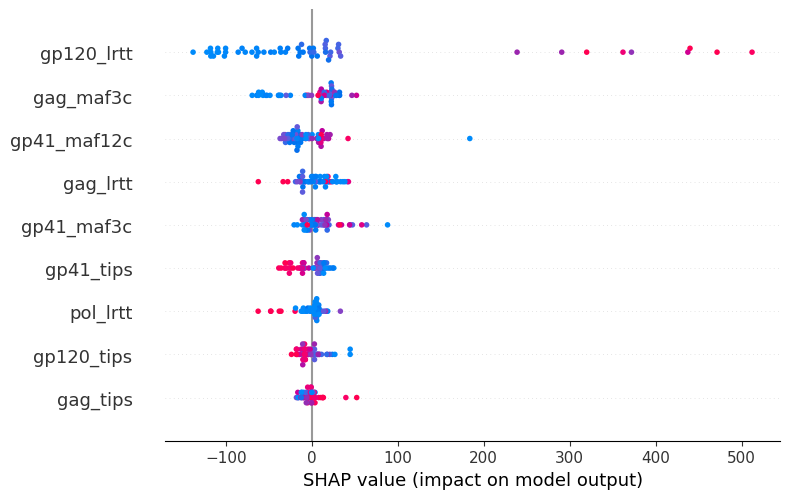

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Create the explainer with the model
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features_of_interest, show = False, color_bar=False)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
plt.savefig('RF_Bots_shap.png', format='png', dpi=300, transparent=True)
plt.show()

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 133682.9688 - mean_absolute_error: 226.7231
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89613.5234 - mean_absolute_error: 185.9659  
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74263.8906 - mean_absolute_error: 179.9263 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61380.2773 - mean_absolute_error: 172.3146 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55544.9414 - mean_absolute_error: 154.2983 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48812.9922 - mean_absolute_error: 146.3801 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44060.5703 - mean_absolute_error: 143.8499 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40731.3555 - mean_absolute_error: 139.8829 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37081.7812 - mean_absolute_error: 136.9702 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34968.2734 - mean_absol

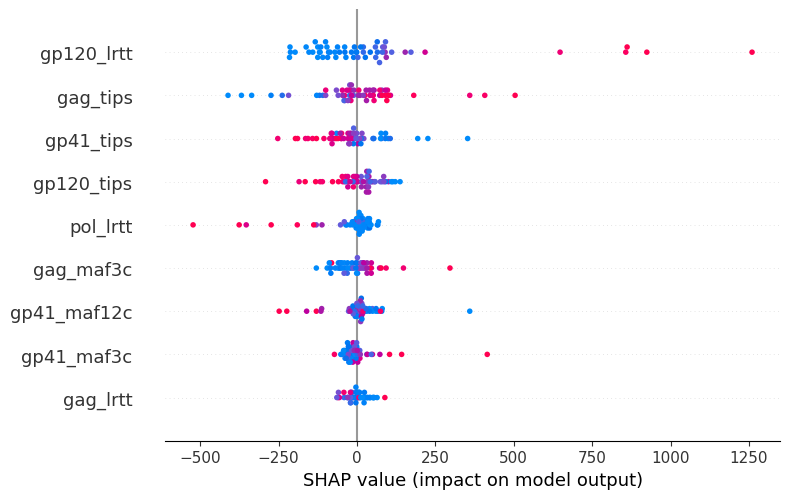

In [ ]:
# Model Configuration
input_shape = X_train.shape[1]  # number of features

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

explainer = shap.GradientExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Assuming shap_values is a list of arrays where each array corresponds to the SHAP values for the model's predictions
shap_values_flattened = [s.reshape(s.shape[0], s.shape[1]) for s in shap_values]

# If shap_values is directly an array, reshape it appropriately
shap_values_flattened = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

shap.summary_plot(shap_values_flattened, X_test, feature_names=features_of_interest, show = False, color_bar=False)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
plt.savefig('MLP_Bots_shap.png', format='png', dpi=300, transparent=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


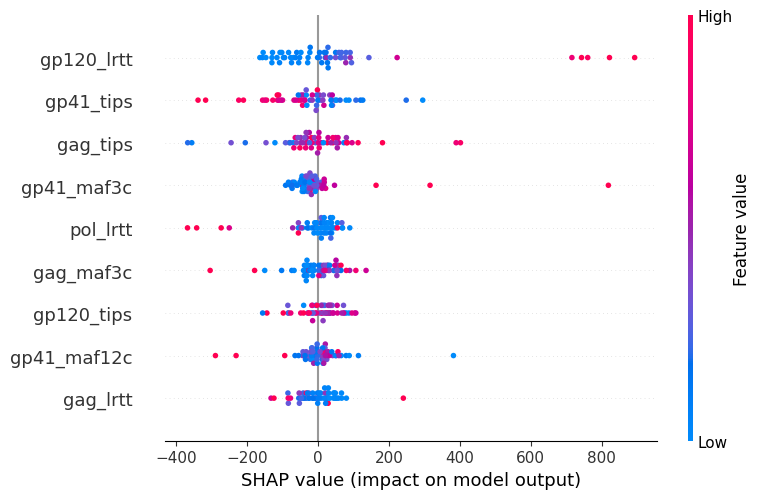

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define your 1D-CNN model
model = tf.keras.Sequential([
        tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='softplus')
])

# Fit the model
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate,
decay_steps=200,
decay_rate=0.95,
staircase=False)  # staircase=False for smooth exponential decay

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0)

explainer = shap.GradientExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Assuming shap_values is a list of arrays where each array corresponds to the SHAP values for the model's predictions
shap_values_flattened = [s.reshape(s.shape[0], s.shape[1]) for s in shap_values]

# If shap_values is directly an array, reshape it appropriately
shap_values_flattened = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

shap.summary_plot(shap_values_flattened, X_test, feature_names=features_of_interest, show = False)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
plt.savefig('CNN_Bots_shap.png', format='png', dpi=300, transparent=True)
plt.show()

**4.3: Uganda dataset**

In [ ]:
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)  # Reshaping y to make it suitable for TensorFlow

# Set up the 20-fold cross-validation
kf = KFold(n_splits=20, shuffle=True, random_state=42)
nmae_scores = []
R2_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    model = tf.keras.Sequential([
            tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
            tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='softplus')
        ])

    # Fit the model
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=120,
            decay_rate=0.95,
            staircase=False)  # staircase=False for smooth exponential decay

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])
    model.fit(X_train, y_train, epochs=120, batch_size=32, verbose=0)

    # Evaluate the model
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    nmae = mae/np.mean(y_test)
    nmae_scores.append(nmae)
    R2_scores.append(r2)

# Bootstrap resampling to compute the 95% confidence interval
n_bootstrap_samples = 1000
bootstrap_means = []
bootstrap_r2 = []

np.random.seed(42)
for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(nmae_scores, size=len(nmae_scores), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(bootstrap_mean)
    bootstrap_sample = np.random.choice(R2_scores, size=len(R2_scores), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_r2.append(bootstrap_mean)

# Calculate the 95% confidence interval
ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)


print(f"Mean MAE: {np.mean(nmae_scores)}")
print(f"Mean R square: {np.mean(R2_scores)}")
print(f"95% Bootstrap Confidence Interval for MAE: ({ci_lower}, {ci_upper})")
ci_lower = np.percentile(bootstrap_r2, 2.5)
ci_upper = np.percentile(bootstrap_r2, 97.5)
print(f"95% Bootstrap Confidence Interval for R square: ({ci_lower}, {ci_upper})")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
Mean MAE: 0.474766458194014
Mean R square: 0.4339403722139325
95% Bootstrap Confidence Interval for MAE: (0.4494743093228821, 0.49730481551573763)
95% Bootstrap Confidence Interval for R square: (0.3896314153259442, 0.48241852965726756)


In [ ]:
# Plot the Shapley values
import shap
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)  # Reshaping y to make it suitable for TensorFlow
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


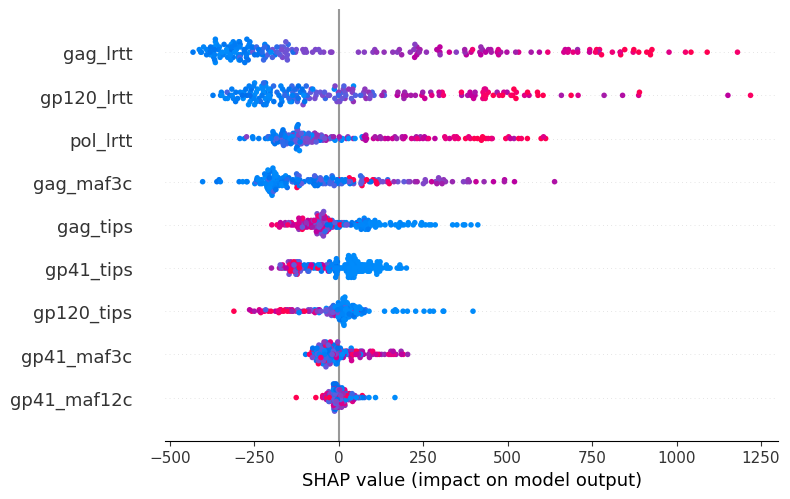

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Create the explainer with the model
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features_of_interest, show = False, color_bar=False)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
plt.savefig('RF_Uganda_shap.png', format='png', dpi=300, transparent=True)
plt.show()

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 2463808.5000 - mean_absolute_error: 1082.2180 - val_loss: 834709.3125 - val_mean_absolute_error: 645.7153
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 952046.7500 - mean_absolute_error: 671.1367 - val_loss: 767492.7500 - val_mean_absolute_error: 671.6061
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 916809.3750 - mean_absolute_error: 671.2916 - val_loss: 755594.5625 - val_mean_absolute_error: 662.5845
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 894433.1875 - mean_absolute_error: 665.7332 - val_loss: 749498.5000 - val_mean_absolute_error: 660.1760
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 887857.3125 - mean_absolute_error: 662.0406 - val_loss: 747007.8750 - val_mean_absolute_error: 660.4900
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 881462.6250 - mean_absolute_error: 659.0531 - val_loss: 743845.0625 - val_mean_absolute_error: 659.9065
Epoch 7/100
40/40 

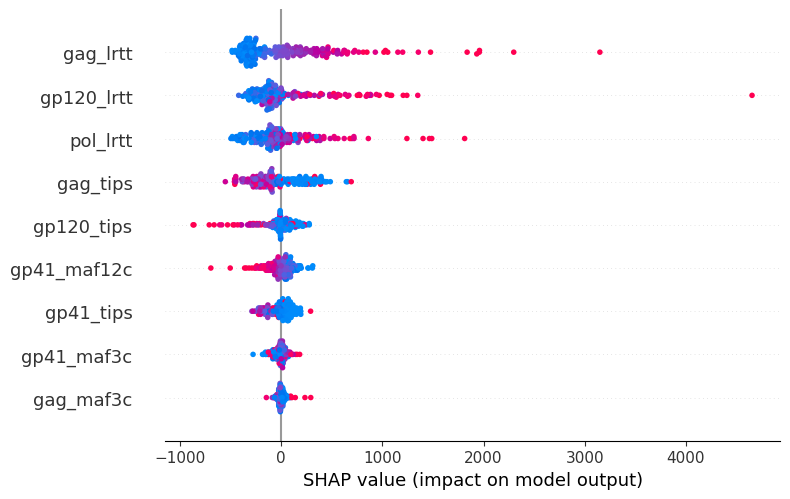

In [ ]:
# Model Configuration
input_shape = X_train.shape[1]  # number of features

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping])

explainer = shap.GradientExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Assuming shap_values is a list of arrays where each array corresponds to the SHAP values for the model's predictions
shap_values_flattened = [s.reshape(s.shape[0], s.shape[1]) for s in shap_values]

# If shap_values is directly an array, reshape it appropriately
shap_values_flattened = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

shap.summary_plot(shap_values_flattened, X_test, feature_names=features_of_interest, show = False, color_bar=False)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
plt.savefig('MLP_Uganda_shap.png', format='png', dpi=300, transparent=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


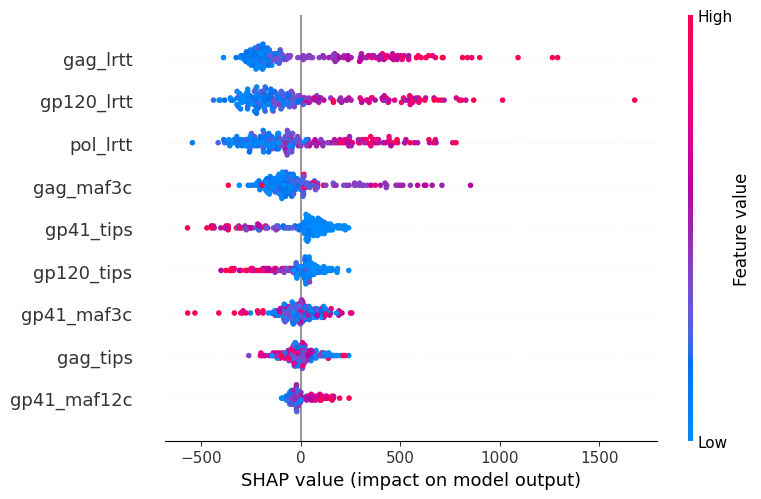

In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define your 1D-CNN model
model = tf.keras.Sequential([
            tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
            tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='softplus')
        ])

# Fit the model
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=120,
            decay_rate=0.95,
            staircase=False)  # staircase=False for smooth exponential decay

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs=120, batch_size=32, verbose=0)

explainer = shap.GradientExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Assuming shap_values is a list of arrays where each array corresponds to the SHAP values for the model's predictions
shap_values_flattened = [s.reshape(s.shape[0], s.shape[1]) for s in shap_values]

# If shap_values is directly an array, reshape it appropriately
shap_values_flattened = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

shap.summary_plot(shap_values_flattened, X_test, feature_names=features_of_interest, show = False)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
plt.savefig('CNN_Uganda_shap.png', format='png', dpi=300, transparent=True)
plt.show()

**4.5: Separated vs. Unified Models**

In [ ]:
# List of features you care about and the target variable
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'  # Replace with your actual target variable

# Filter the dataframe to include only the desired features and the target variable
df_filtered = df[features_of_interest + [target_variable, 'multiple_inf']]

# Separate numerical features and the categorical feature
numerical_features = df_filtered[features_of_interest + [target_variable]]
categorical_feature = df_filtered[['multiple_inf']]

# Step 1: Impute missing values using KNN for numerical features only
imputer = KNNImputer(n_neighbors=5)
numerical_features_imputed = imputer.fit_transform(numerical_features)

# Convert the imputed numerical data back to a DataFrame
numerical_features_imputed = pd.DataFrame(numerical_features_imputed, columns=features_of_interest + [target_variable])

# Merge the imputed numerical features back with the categorical feature
df_imputed = pd.concat([numerical_features_imputed, categorical_feature.reset_index(drop=True)], axis=1)

# Separate features and target variable
X = df_imputed[features_of_interest + ['multiple_inf']]
y = df_imputed[target_variable]
# Step 2: Standardize only the numerical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[features_of_interest] = scaler.fit_transform(X[features_of_interest])

# Convert DataFrame sections to numpy arrays for proper indexing
X_mono = X_scaled[df_imputed['multiple_inf'] == 'Mono infection'][features_of_interest].values
y_mono = y[df_imputed['multiple_inf'] == 'Mono infection'].values
X_multi = X_scaled[df_imputed['multiple_inf'] == 'Multiple infection'][features_of_interest].values
y_multi = y[df_imputed['multiple_inf'] == 'Multiple infection'].values

# Updated perform_cv function to use numpy array indexing correctly
def perform_cv(X_data, y_data, kf):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    nmae_scores = []
    R2_scores = []
    indices = []

    for train_index, test_index in kf.split(X_data):
        indices.append((train_index, test_index))
        X_train, X_test = X_data[train_index], X_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        nmae = mean_absolute_error(y_test, y_pred)/np.mean(y_test)
        nmae_scores.append(nmae)
        R2_scores.append(r2_score(y_test, y_pred))

    return nmae_scores, R2_scores, indices

kf = KFold(n_splits=20, shuffle=True, random_state=42)
mae_mono, r2_mono, indices_mono = perform_cv(X_mono, y_mono, kf)
mae_multi, r2_multi, indices_multi = perform_cv(X_multi, y_multi, kf)

# Combine indices for training/testing across both groups for one-model evaluation
X_combined = np.vstack((X_mono, X_multi))
y_combined = np.concatenate((y_mono, y_multi))

# Use combined indices to train and evaluate a single model
mae_combined, r2_combined, _ = perform_cv(X_combined, y_combined, kf)
mae_separate = mae_mono + mae_multi
r2_separate = r2_mono + r2_multi
# Display results
print("Separated Models - MAE:", np.mean(mae_separate), "R2:", np.mean(r2_separate))


np.random.seed(42)
n_bootstrap_samples = 1000
bootstrap_means = []
bootstrap_r2 = []

np.random.seed(42)
for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(mae_separate, size=len(mae_separate), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(bootstrap_mean)
    bootstrap_sample = np.random.choice(r2_separate, size=len(r2_separate), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_r2.append(bootstrap_mean)

# Calculate the 95% confidence interval
ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)
print(f"95% Bootstrap Confidence Interval for NMAE: ({ci_lower}, {ci_upper})")
ci_lower = np.percentile(bootstrap_r2, 2.5)
ci_upper = np.percentile(bootstrap_r2, 97.5)
print(f"95% Bootstrap Confidence Interval for R square: ({ci_lower}, {ci_upper})")


n_bootstrap_samples = 1000
bootstrap_means = []
bootstrap_r2 = []

np.random.seed(42)
for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(mae_combined, size=len(mae_combined), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(bootstrap_mean)
    bootstrap_sample = np.random.choice(r2_combined, size=len(r2_combined), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_r2.append(bootstrap_mean)
print("Combined Model - MAE:", np.mean(mae_combined), "R2:", np.mean(r2_combined))
# Calculate the 95% confidence interval
ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)
print(f"95% Bootstrap Confidence Interval for NMAE: ({ci_lower}, {ci_upper})")
ci_lower = np.percentile(bootstrap_r2, 2.5)
ci_upper = np.percentile(bootstrap_r2, 97.5)
print(f"95% Bootstrap Confidence Interval for R square: ({ci_lower}, {ci_upper})")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Separated Models - MAE: 0.6735008478121735 R2: -1.9798651351152756
Combined Model - MAE: 0.5123499154098403 R2: 0.23707811520056693
95% Bootstrap Confidence Interval for NMAE: (0.555383402916919, 0.8310083318872411)
95% Bootstrap Confidence Interval for R square: (-3.8801261825746143, -0.5679349380936014)
95% Bootstrap Confidence Interval for NMAE: (0.45140259480512257, 0.5750303803951801)
95% Bootstrap Confidence Interval for R square: (0.028819891892581207, 0.45045054740800294)


**4.6: Zero-shot Learning**

In [5]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Assuming 'df' and 'Rakai_MAF' are loaded with your data
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing for Rakai dataset
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)

model = tf.keras.Sequential([
        tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
        tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='softplus')
    ])

# Fit the model
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=120,
        decay_rate=0.95,
        staircase=False)  # staircase=False for smooth exponential decay

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
model.fit(X_scaled, y, epochs=120, batch_size=32, verbose=0)

# Prepare Botswana dataset for transfer learning
df_filtered = df[features_of_interest + [target_variable]]
df_imputed = imputer.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed, columns=features_of_interest + [target_variable])
X_trans = df_imputed[features_of_interest]
y_trans = df_imputed[target_variable]
X_scaled_trans = scaler.fit_transform(X_trans)

n_bootstraps = 1000
n_samples = 200

nmae_scores = []
R2_scores = []

for i in range(n_bootstraps):
    # Bootstrap sampling from the testing set
    indices = np.random.choice(range(len(X_scaled_trans)), size=n_samples, replace=True)
    X_sample = X_scaled_trans[indices]
    y_sample = y_trans.iloc[indices].values
    y_pred = model.predict(X_sample)
    nmae = mean_absolute_error(y_sample, y_pred)/np.mean(y_sample)
    nmae_scores.append(nmae)
    R2_scores.append(r2_score(y_sample, y_pred))

# Convert results to numpy arrays for easier analysis
nmae_scores = np.array(nmae_scores)
R2_scores = np.array(R2_scores)
print("Mean MAE: ", np.mean(nmae_scores), "Mean R-squared scores: ", np.mean(R2_scores))

ci_lower = np.percentile(nmae_scores, 2.5)
ci_upper = np.percentile(nmae_scores, 97.5)
print("MAE Bootstrap interval: (", ci_lower, ci_upper, ")")

ci_lower = np.percentile(R2_scores, 2.5)
ci_upper = np.percentile(R2_scores, 97.5)
print("MAE Bootstrap interval: (", ci_lower, ci_upper, ")")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━

**4.7: Few-shot Learning**

1D-CNN Model

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Assuming 'df' and 'Rakai_MAF' are loaded with your data
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing for Rakai dataset
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)

model = tf.keras.Sequential([
        tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
        tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='softplus')
    ])

# Fit the model
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=120,
        decay_rate=0.95,
        staircase=False)  # staircase=False for smooth exponential decay

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
model.fit(X_scaled, y, epochs=120, batch_size=32, verbose=0)

# Prepare Botswana dataset for transfer learning
df_filtered = df[features_of_interest + [target_variable]]
df_imputed = imputer.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed, columns=features_of_interest + [target_variable])
X_trans = df_imputed[features_of_interest]
y_trans = df_imputed[target_variable]
X_scaled_trans = scaler.fit_transform(X_trans)

seed = 42
# Sample 5% of the Botswana dataset for fine-tuning
df_sample = df_imputed.sample(frac=0.05, random_state=seed)
X_sample = df_sample[features_of_interest]
X_scaled_sample = scaler.fit_transform(X_sample)
y_sample = df_sample[target_variable]

testing_df = df_imputed.drop(df_sample.index)
X_test = testing_df[features_of_interest]
X_scaled_test = scaler.fit_transform(X_test)
y_test = testing_df[target_variable]

# Freeze all layers initially
for layer in model.layers:
    layer.trainable = False

# Unfreeze only the desired Dense layers for fine-tuning
for layer in model.layers[-3:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
fine_tune_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.018,  # Lower learning rate for fine-tuning
    decay_steps=120,
    decay_rate=0.95,
    staircase=False  # Smooth exponential decay
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr_schedule),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Fine-tune the model on the 5% sample of the Botswana dataset
model.fit(X_scaled_sample, y_sample, epochs=120, batch_size=16, verbose=1)

n_bootstraps = 1000
n_samples = 200

nmae_scores = []
R2_scores = []

for i in range(n_bootstraps):
    # Bootstrap sampling from the testing set
    indices = np.random.choice(range(len(X_scaled_test)), size=n_samples, replace=True)
    X_sample = X_scaled_test[indices]
    y_sample = y_test.iloc[indices].values
    y_pred = model.predict(X_sample)
    nmae = mean_absolute_error(y_sample, y_pred)/np.mean(y_sample)
    nmae_scores.append(nmae)
    R2_scores.append(r2_score(y_sample, y_pred))

# Convert results to numpy arrays for easier analysis
nmae_scores = np.array(nmae_scores)
R2_scores = np.array(R2_scores)
print("Mean MAE: ", np.mean(nmae_scores), "Mean R-squared scores: ", np.mean(R2_scores))

ci_lower = np.percentile(nmae_scores, 2.5)
ci_upper = np.percentile(nmae_scores, 97.5)
print("MAE Bootstrap interval: (", ci_lower, ci_upper, ")")

ci_lower = np.percentile(R2_scores, 2.5)
ci_upper = np.percentile(R2_scores, 97.5)
print("MAE Bootstrap interval: (", ci_lower, ci_upper, ")")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 903621.6250 - mean_absolute_error: 704.2905
Epoch 2/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 718566.6250 - mean_absolute_error: 650.7176
Epoch 3/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 715422.8750 - mean_absolute_error: 671.7104
Epoch 4/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 473631.0625 - mean_absolute_error: 529.4781
Epoch 5/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 226305.4844 - mean_absolute_error: 359.9673
Epoch 6/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 165447.8281 - mean_absolute_error: 335.6633
Epoch 7/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 141368.6562 - mean_absolute_error: 312.8798
Epoch 8/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 116297.1875 - mean_absolute_error: 285.5706
Epoch 9/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 151953.1562 - mean_absolute_error: 327.4291
Epoch 10/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 100706.8984 - mean_absolute_error

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 903621.6250 - mean_absolute_error: 704.2905
Epoch 2/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 718566.6250 - mean_absolute_error: 650.7176
Epoch 3/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 715422.8750 - mean_absolute_error: 671.7104
Epoch 4/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 473631.0625 - mean_absolute_error: 529.4781
Epoch 5/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 226305.4844 - mean_absolute_error: 359.9673
Epoch 6/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 165447.8281 - mean_absolute_error: 335.6633
Epoch 7/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 141368.6562 - mean_absolute_error: 312.8798
Epoch 8/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 116297.1875 - mean_absolute_error: 285.5706
Epoch 9/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 151953.1562 - mean_absolute_error: 327.4291
Epoch 10/120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 100706.8984 - mean_absolute_error:

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


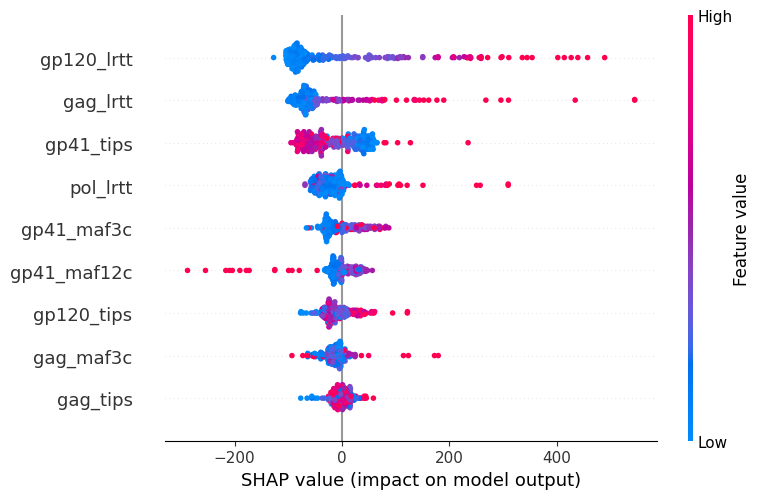

In [ ]:
# Plot the Shapley values
import shap
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Assuming 'df' and 'Rakai_MAF' are loaded with your data
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing for Rakai dataset
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)

model = tf.keras.Sequential([
        tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
        tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='softplus')
    ])

# Fit the model
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=120,
        decay_rate=0.95,
        staircase=False)  # staircase=False for smooth exponential decay

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
model.fit(X_scaled, y, epochs=120, batch_size=32, verbose=0)

# Prepare Botswana dataset for transfer learning
df_filtered = df[features_of_interest + [target_variable]]
df_imputed = imputer.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed, columns=features_of_interest + [target_variable])
X_trans = df_imputed[features_of_interest]
y_trans = df_imputed[target_variable]
X_scaled_trans = scaler.fit_transform(X_trans)

# Sample 5% of the Botswana dataset for fine-tuning
df_sample = df_imputed.sample(frac=0.05, random_state=seed)
X_sample = df_sample[features_of_interest]
X_scaled_sample = scaler.fit_transform(X_sample)
y_sample = df_sample[target_variable]

testing_df = df_imputed.drop(df_sample.index)
X_test = testing_df[features_of_interest]
X_scaled_test = scaler.fit_transform(X_test)
y_test = testing_df[target_variable]

# Freeze all layers initially
for layer in model.layers:
    layer.trainable = False

# Unfreeze only the desired Dense layers for fine-tuning
for layer in model.layers[-3:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
fine_tune_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.018,  # Lower learning rate for fine-tuning
    decay_steps=120,
    decay_rate=0.95,
    staircase=False  # Smooth exponential decay
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr_schedule),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Fine-tune the model on the 5% sample of the Botswana dataset
model.fit(X_scaled_sample, y_sample, epochs=120, batch_size=16, verbose=1)

# Create a DeepExplainer
explainer = shap.DeepExplainer(model, X_scaled_sample)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_scaled_test)

# Assuming shap_values is a list of arrays where each array corresponds to the SHAP values for the model's predictions
shap_values_flattened = [s.reshape(s.shape[0], s.shape[1]) for s in shap_values]

# If shap_values is directly an array, reshape it appropriately
shap_values_flattened = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

shap.summary_plot(shap_values_flattened,X_test, feature_names=features_of_interest, show = False)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
plt.savefig('CNN_untune_shap.png', format='png', dpi=300, transparent=True)
plt.show()

**Subset selection**

Reverse engineering

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Assuming 'df' and 'Rakai_MAF' are loaded with your data
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing for Rakai dataset
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)

model = tf.keras.Sequential([
        tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
        tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='softplus')
    ])

# Fit the model
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=120,
        decay_rate=0.95,
        staircase=False)  # staircase=False for smooth exponential decay

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
model.fit(X_scaled, y, epochs=120, batch_size=32, verbose=0)

# Prepare Botswana dataset for transfer learning
df_filtered = df[features_of_interest + [target_variable]]
df_imputed = imputer.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed, columns=features_of_interest + [target_variable])
X_trans = df_imputed[features_of_interest]
y_trans = df_imputed[target_variable]
X_scaled_trans = scaler.fit_transform(X_trans)

num_tries = 30
nmae_scores = []
R2_scores = []

for iter in range(num_tries):
    # Sample 5% of the Botswana dataset for fine-tuning
    df_sample = df_imputed.sample(frac=0.05, random_state=iter)
    X_sample = df_sample[features_of_interest]
    X_scaled_sample = scaler.fit_transform(X_sample)
    y_sample = df_sample[target_variable]

    testing_df = df_imputed.drop(df_sample.index)
    X_test = testing_df[features_of_interest]
    X_scaled_test = scaler.fit_transform(X_test)
    y_test = testing_df[target_variable]

    # Freeze all layers initially
    for layer in model.layers:
        layer.trainable = False

    # Unfreeze only the desired Dense layers for fine-tuning
    for layer in model.layers[-3:]:
        layer.trainable = True

    # Compile the model with a lower learning rate for fine-tuning
    fine_tune_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.018,  # Lower learning rate for fine-tuning
        decay_steps=120,
        decay_rate=0.95,
        staircase=False  # Smooth exponential decay
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    # Fine-tune the model on the 5% sample of the Botswana dataset
    model.fit(X_scaled_sample, y_sample, epochs = 50, batch_size=16, verbose=1)

    y_pred = model.predict(X_scaled_test)
    nmae = mean_absolute_error(y_test, y_pred)/np.mean(y_test)
    nmae_scores.append(nmae)
    R2_scores.append(r2_score(y_test, y_pred))

    if iter == 0:
      max_nmae = nmae
      min_nmae = nmae
      best_seed = iter
      worst_seed = iter
    elif nmae < min_nmae:
      best_seed = iter
      min_nmae = nmae
    elif nmae > max_nmae:
      worst_seed = iter
      max_nmae = nmae

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1492971.8750 - mean_absolute_error: 1041.6057
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1549580.6250 - mean_absolute_error: 1013.7783
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 866445.9375 - mean_absolute_error: 833.4259
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 821804.5000 - mean_absolute_error: 812.0847
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 401267.8125 - mean_absolute_error: 554.8058
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 250172.4062 - mean_absolute_error: 430.9904
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 249446.7500 - mean_absolute_error: 426.4297
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 218111.6562 - mean_absolute_error: 386.1563
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 136036.9688 - mean_absolute_error: 306.9362
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 135038.0938 - mean_absolute_error: 307.815

In [ ]:
# Assuming 'df' and 'Rakai_MAF' are loaded with your data
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing for Rakai dataset
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)

In [ ]:
print(ReverseEng_nmae)
print(ReverseEng_R2)
print(len(ReverseEng_nmae))
print(len(ReverseEng_R2))

[0.6763999112882432, 0.7144141998451465, 0.7050890928059941, 0.7036946983273531, 0.7203563636128282, 0.7287580395371479, 0.7039175333886282, 0.7574141863533492, 0.7714443745103168, 0.7171823404992826, 0.9327578335548475, 0.8804018052854007, 0.7096377008070249, 0.8451643196756984, 0.9595993145199617, 0.6992321294344209, 0.6834598569693736, 0.7834134195339253, 0.6928323259808148, 0.7542128562975154, 0.6911968095497119, 0.6872467463313201, 0.7527410169075394, 0.6965118499725398, 0.668662146519671, 0.7936964299469812, 0.716471401849252, 0.663137938116161, 0.722258764564965, 0.6899134002033451, 0.7507486903586175, 0.6613030852716881, 0.6622523349512409, 0.6645266710228066, 0.6892834089906675, 0.7346112029629903, 0.6157091569645373, 0.6833206341982181, 0.6352624076451058, 0.745117159696289, 0.7188559934396053, 0.6444182343315088, 0.8794935418915911, 0.6730932855474764, 0.6519957272726512, 0.6934324001198681, 0.6774042174082812, 0.6595660421739052, 0.6407068720349334, 0.6168860333545839, 0.71

In [ ]:
ReverseEng_nmae = [0.6763999112882432, 0.7144141998451465, 0.7050890928059941, 0.7036946983273531, 0.7203563636128282, 0.7287580395371479, 0.7039175333886282, 0.7574141863533492, 0.7714443745103168, 0.7171823404992826, 0.9327578335548475, 0.8804018052854007, 0.7096377008070249, 0.8451643196756984, 0.9595993145199617, 0.6992321294344209, 0.6834598569693736, 0.7834134195339253, 0.6928323259808148, 0.7542128562975154, 0.6911968095497119, 0.6872467463313201, 0.7527410169075394, 0.6965118499725398, 0.668662146519671, 0.7936964299469812, 0.716471401849252, 0.663137938116161, 0.722258764564965, 0.6899134002033451, 0.7507486903586175, 0.6613030852716881, 0.6622523349512409, 0.6645266710228066, 0.6892834089906675, 0.7346112029629903, 0.6157091569645373, 0.6833206341982181, 0.6352624076451058, 0.745117159696289, 0.7188559934396053, 0.6444182343315088, 0.8794935418915911, 0.6730932855474764, 0.6519957272726512, 0.6934324001198681, 0.6774042174082812, 0.6595660421739052, 0.6407068720349334, 0.6168860333545839, 0.7192324584459188, 0.7043605106352803, 0.7309101812093887, 0.8321290524573075, 0.6879292773938664, 0.6941437914155292, 0.7030992073638642, 0.707273031093737, 0.8680434819275383, 0.7646610809987191, 0.7149445447261062, 0.7242982422278943, 0.7951573421884431, 0.6213942580032944, 0.6319653489352767, 0.704623560928576, 0.7607230567126003, 0.6523242626376786, 0.6889407270791308, 0.6894153154133805, 0.628359214108401, 0.6318427138663644, 0.7037209996075774, 0.6664548999966656, 0.6989675503762628, 0.662581699794893, 0.6655826152699957, 0.6798964703953718, 0.8638337717800703, 0.6601793661338055, 0.8647430706146922, 0.6655322634117551, 0.8805370422978172, 0.6711834869357263, 0.6610399279602888, 1.0464609080767182, 0.6554515857494007, 0.5927643534002147, 0.6237371396675981, 0.6238637685049916, 0.8210858171459336, 0.8045079830383847, 0.726137144863986, 0.7535316449093177, 0.8357276466493274, 0.6907404932400225, 0.7469046244850935, 0.7343000177918981, 0.8407815536438715, 0.6682933100917777, 0.6881109488862654, 0.8758608402287269, 0.7025723838624459, 0.7369336239361567, 0.6160711175854694, 0.6309673825311294, 0.6935999550379233, 0.6818831446436661, 0.5997301903114971, 0.5853248917132291, 0.6337823955233965, 0.6563467786896507, 0.5758348515732741, 0.6735030635332205, 0.6113045380204742, 0.6011920787377022, 0.6274492700805842, 0.6770646119627989, 0.6609319131234004, 0.6554575963739724, 0.6386601206106332, 0.6937793622921815, 0.6553620028636175, 0.6432538139119252, 0.6405963127599883, 0.6870541645670916, 0.5903254014734506, 0.6492467779974692, 0.8034441501861361, 0.6388858320152714, 0.6681279455872251, 0.5933092717637761, 0.6185762252155713, 0.6504093362933437, 0.6400305630637053, 0.7583460061119104, 0.7638131855590454, 0.7294287017274642, 0.6693059008250499, 0.6592091571656608, 0.5776299951471036, 0.7200690891323885, 0.6029387538518619, 0.6682878708857259, 0.624693645258395, 0.6551808738299773, 0.7681150710228511, 0.6485089554094989, 0.6419042609539416, 0.6396678385013127, 0.6432348723839716, 0.5935534080471948, 0.8892811146205838, 0.6730610048217606, 0.7592996941078397, 0.6133884197384797, 0.6551608224511807, 0.6621774041546602, 0.8810208714122186, 0.7161540280580764, 0.8892912628981999, 0.7299705177870912, 0.6489876921507723, 0.5891952990833738, 0.6902327241458307, 0.6520009872958302, 0.6386529694334625, 0.6439066467822436, 0.624426992996262, 0.6489436209227694, 0.672352193295369, 0.6907342809338413, 0.6977028839564643, 0.6798166846957451, 0.6697336907751535, 0.6322851702140163, 0.6754703039403057, 0.8934323705953612, 0.6622320540902641, 0.6009592177374984, 0.6177495465293469, 0.6770145468224276, 0.6062887309302045, 0.6423392313408507, 0.6418848783024932, 0.6356794555435886, 0.6440163421169325, 0.7947330244364637, 0.6288166336607212, 0.6429154467451893, 0.6105816337853026, 0.6178187721974181, 0.6392542038731962, 0.6257436822477096, 0.8200881397749458, 0.7306854360572466, 0.6177383186142563, 0.5968560999680479, 0.6505495529214628, 0.7049195401634982, 0.9543587815672121, 0.6345127295072067, 0.6276875048507713, 0.712822690449378, 0.6851199597402851, 0.6208363860550394, 0.7025909901078935, 0.6021018063619643, 0.6287702560161684, 0.6338033277996302, 0.6558421200468137, 0.8250682292511248, 0.6746111556172413, 0.6970701304198058, 0.6074728694276904, 0.809692833106865, 0.7197519150607571, 0.6203731773319325, 0.6207313703070355, 0.6923677535353345, 0.6233190532795433, 0.6944552874340778, 0.9363065115816465, 0.5903507612062852, 0.6031937983045886, 0.6708978006615891, 0.6071451928283529, 0.6453743391433782, 0.6569985509398178, 0.6309321660464987, 0.7594668847839926, 0.6401062470663028, 0.6444984420842914, 0.6310735054252831, 0.6458916512407109, 0.6874922159979943, 0.6142143148777842, 0.637554633024295, 0.7487630880003977, 0.6419785870429151, 0.5976553405438831, 0.5803185000469582, 0.6859560416537006, 0.8678824245242852, 0.6883217783820542, 0.6437806647632094, 0.6406025473899472, 0.6844150034049936, 0.597738293498624, 0.6368787654722053, 0.6473115011164305, 0.743342533105423, 0.6623452036377068, 0.6537384889423409, 0.6887838516831257, 0.6400915758615597, 0.6339520693220142, 0.6792307019096039, 0.6265683872346958, 0.6756245241647718, 0.6407396507618272, 0.6782813893048143, 0.6854528245503305, 0.6227129094624504, 0.686728201857021, 0.6859453263785608, 0.6700076147206566, 0.6083225209337727, 0.5978389707916135, 0.6318634438075454, 0.6758469919658596, 0.6533369963239077, 0.6869615127908132, 0.7118992850380877, 0.6883829479765595, 0.6797926539738566, 0.6685462753386301, 0.6442794689091478, 0.6172443589070868, 0.6271373866462507, 0.6014246923495222, 0.6156395739131487, 0.6768815890812488, 0.8787110565542348, 0.5904994276871782, 0.6201715493562612, 0.7255258879262944, 0.623085769626552, 0.9896522827852429, 0.6205013571962464, 0.6766830450558591, 0.6081849283143471, 0.5924257202181994, 0.8846923293322914, 0.5898350120577671, 0.6610584748270443, 0.635880434953629, 0.574309662901925, 0.6283871310278253, 0.5821840552516965]
ReverseEng_R2 = [0.05374899756856644, 0.009607451451040694, -0.003927504340078158, -0.12069103755911303, -0.029230179138049595, 0.012381240673744687, 0.03371277683477503, 0.03464528687199353, -0.08964678063454978, 0.07794391217090468, -0.17447156092329474, -0.09541708316372666, 0.10837232375602324, -0.08126988635187193, -0.3567202688854312, 0.039699888693300434, 0.13842554430063658, -0.0751607652263293, 0.23386202100136222, -0.0375389106423889, 0.04083732219592362, 0.15637033163260372, -0.25469616553166574, 0.07084225122974197, 0.007338745838423644, 0.007034430803897984, 0.150158006949634, 0.10607093225762954, 0.08504977142008707, 0.19732420192571531, 0.014749927695089426, 0.1142920833340233, 0.16736329765719982, 0.19383480628229166, 0.20401734375271652, 0.22434124710756476, 0.11772020232343927, 0.056801796180559916, 0.28955176268925775, 0.0004522885007374189, 0.11133335227377394, 0.033438179868915174, -0.4352321276913613, 0.12536530878905916, 0.11279190774155223, 0.19425981801613468, 0.10285223317977155, 0.17843292405261357, 0.03293163287136425, 0.20337592556647321, -0.1830203810093276, 0.09301493507958425, 0.010339837926103379, -0.10679547122828525, 0.07155573842516216, 0.21982600658785156, 0.07736874581060549, -0.0482220015425503, -0.14091294536810484, -0.11770855895643062, -0.05444264627032713, -0.1483091106032417, -0.16666101040866677, 0.29528034730880504, 0.11203806397016747, 0.025768372083884605, -0.13322791876929108, 0.10087532307905067, 0.08273120699596781, 0.12603410943783155, 0.1412882125047087, 0.0969639871477389, -0.07502542738867879, 0.13502185336517336, -0.027587931092268647, -0.04397662727461804, 0.037038354171525456, -0.08612030621670308, -0.29462987935443863, -0.05863714033707024, -0.4330915459245732, 0.28147453421115753, 0.08939702846004327, 0.09751931581591833, 0.14307404528379963, -0.4705976114692254, 0.22530323558259657, 0.2659379322443166, 0.1694540187277498, 0.19753548460846437, -0.25832225011838084, -0.24398648892027874, 0.05686897087942677, -0.3431618923115314, -0.5777770489978362, -0.003725608358412291, 0.0067742605187630645, -0.09374062005190487, -0.0757168989345276, 0.0910148571546956, -0.06270778531203769, 0.02918726409121908, 0.18658508376913308, 0.03105308255041206, 0.27366258704141455, 0.08267656121732658, -0.012467540748009931, 0.1923835118297902, 0.2432649580896198, 0.3626481821061245, 0.14592730066691606, 0.013965786212291054, 0.3400914663895699, 0.003971498626163639, 0.16739744630880382, 0.3059437851504522, 0.15889797080396917, -0.06604193122402724, 0.1785398268110191, 0.22494949811969311, 0.1927880466425771, 0.04223307689705458, 0.1320473937374852, 0.09305148804334329, 0.15533819284047123, 0.14390530871857443, 0.282260003598906, 0.16058698114390768, 0.11826151118614248, 0.29048545742127085, 0.15594190283809328, 0.22915136334706032, 0.2681219491492094, 0.2124364024570904, -0.007701265433598392, 0.03570687892276736, 0.08997119581165147, -0.1590584241178088, 0.2934518119219869, 0.009362640132655864, 0.30595095088910385, -0.05646226023216294, 0.2853675177639554, 0.1441539483511588, 0.23275466075404327, 0.12528042597756517, -0.11754141511407457, 0.04962586415418502, 0.2370635261239491, 0.09861813493555804, 0.23030601609632784, 0.42336794286665647, -0.3019836512494942, 0.16653960594703188, 0.04582358868806646, 0.18472488476773208, 0.1551428355515051, 0.26642888813396026, -0.08544005675311594, -0.11784933344375625, -0.1553633805761101, 0.2057427357091567, 0.15953285672372475, 0.3103809554199708, 0.002964804694527867, 0.13341160646895922, 0.17218914422095533, 0.23260251519139152, 0.1906865244014927, 0.006491915687617866, -0.05242879899746833, 0.14872051745610393, 0.010897043392571581, -0.04067764787635375, 0.051013062212128535, 0.07517205551284767, 0.22516455486846643, -0.360838003176398, 0.3589415847911266, 0.18772164551497306, 0.42994663414054857, 0.061802619628243516, 0.231740604546413, 0.18365851771086183, 0.25837380636901264, 0.06847380281833626, 0.24820551280766945, 0.047123052657630615, 0.2799294391439998, 0.19820812869187054, 0.34421710522986093, 0.09083216895988366, 0.16926880127356547, 0.19777793699888357, -0.1276092783718501, -0.17658279599219662, 0.15089774244158172, 0.14000897666231382, 0.0032256001298504033, -0.17857302236073824, -0.21199649691804745, 0.1993239611945078, 0.2765897026848433, 0.1312483953899365, 0.3234075138263385, 0.23443780377285517, -0.12749753393855556, 0.23449076072754083, 0.076169373865419, 0.08018644715912271, 0.08122802717944766, -0.27585644300353573, 0.06841777096629309, -0.049785113444886786, 0.31123070468750824, -0.23955853098467705, 0.21328215520236748, 0.1693062690818833, 0.22010736469080872, -0.0641974380404644, 0.21184833216964272, 0.13324654459595842, -0.28601661707483417, 0.33565924501444644, 0.12895220176007494, 0.25134191441379283, 0.18748987551473617, 0.3403748403124258, 0.14418883292565743, 0.26125460149846513, -0.05362371885325512, 0.22495286262272052, 0.33520320628312694, 0.0252693121597376, 0.13581777956892038, 0.33566937330087754, 0.363377741890034, 0.3679584292225935, 0.060282669927820165, 0.1350578982583749, 0.3445381552171479, 0.2847200853425901, -0.034980437757648364, -0.21282771683825552, 0.3228466986343951, 0.3936722083793105, 0.13811224774168174, 0.12259338438598966, 0.3136556562215971, 0.06360595643122402, 0.11497635014330898, 0.09371548472363989, 0.13327495818199386, 0.2920318849111396, 0.16204889601254557, 0.04210252174619611, 0.04910662729130166, -0.0518956238232271, 0.23753498996076516, 0.0146433913095938, 0.10962238395755797, 0.2189395195634748, 0.08044578714952688, 0.10023182737156855, -0.11371897227590355, -0.13231462136876293, 0.11735624047323812, 0.24947747202187598, 0.2920250975104486, 0.02787021963083358, 0.2591236645427679, -0.01608575787875499, -0.17176044736230112, 0.018592529225041954, 0.06367373848354141, 0.018958455083334935, -0.045546855257615704, 0.09199628630812373, 0.13716590259249772, 0.21327008330567565, 0.2731946222427588, 0.14454925224258341, -0.09806207344633444, -0.19707817233116676, 0.25060543334218466, 0.11406500210348758, 0.22196350433601741, 0.24586084296975574, -0.060697422169657234, 0.12921498383097285, 0.06112419352724907, 0.2818043419673063, 0.24782965606768326, -0.3355382928188013, 0.3453356259434638, -0.008854455616584822, 0.16146624505716278, 0.28777578731904485, 0.21792098466262178, 0.16997768628932908]
print("Mean NMAE: ", np.mean(ReverseEng_nmae))
print("Mean R-squared: ", np.mean(ReverseEng_R2))

# Bootstrap confidence intervals for NMAE and R²
nmae_ci_lower = np.percentile(ReverseEng_nmae, 2.5)
nmae_ci_upper = np.percentile(ReverseEng_nmae, 97.5)
print("NMAE Bootstrap interval: (", nmae_ci_lower, ",", nmae_ci_upper, ")")

r2_ci_lower = np.percentile(ReverseEng_R2, 2.5)
r2_ci_upper = np.percentile(ReverseEng_R2, 97.5)
print("R² Bootstrap interval: (", r2_ci_lower, ",", r2_ci_upper, ")")
def second_largest_index(lst):
    # Find the unique sorted values in the list in descending order
    unique_sorted_lst = sorted(set(lst), reverse=True)

    # Find the second largest value
    second_largest_value = unique_sorted_lst[1]
    second_smallest_value = unique_sorted_lst[-2]
    # Find the index of the second largest value
    index_of_second_largest = lst.index(second_largest_value)
    index_of_second_smallest = lst.index(second_smallest_value)
    return index_of_second_smallest, index_of_second_largest

second_largest_index(ReverseEng_nmae)

Mean NMAE:  0.6863837474278849
Mean R-squared:  0.08576306761785986
NMAE Bootstrap interval: ( 0.5900679470302168 , 0.8892864424663323 )
R² Bootstrap interval: ( -0.31959983807338044 , 0.3449568273484637 )


(112, 288)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


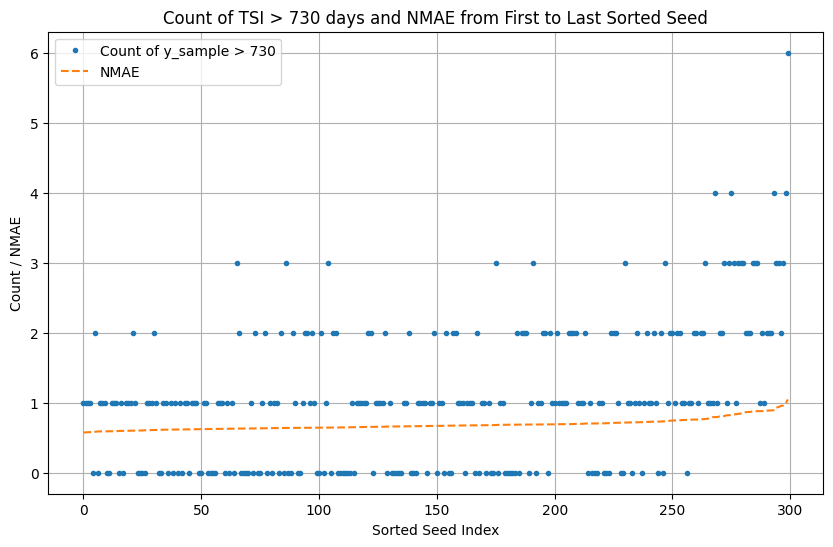

In [ ]:
df_filtered = df[features_of_interest + [target_variable]]
df_imputed = imputer.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed, columns=features_of_interest + [target_variable])

ReverseEng_nmae = [0.6763999112882432, 0.7144141998451465, 0.7050890928059941, 0.7036946983273531, 0.7203563636128282, 0.7287580395371479, 0.7039175333886282, 0.7574141863533492, 0.7714443745103168, 0.7171823404992826, 0.9327578335548475, 0.8804018052854007, 0.7096377008070249, 0.8451643196756984, 0.9595993145199617, 0.6992321294344209, 0.6834598569693736, 0.7834134195339253, 0.6928323259808148, 0.7542128562975154, 0.6911968095497119, 0.6872467463313201, 0.7527410169075394, 0.6965118499725398, 0.668662146519671, 0.7936964299469812, 0.716471401849252, 0.663137938116161, 0.722258764564965, 0.6899134002033451, 0.7507486903586175, 0.6613030852716881, 0.6622523349512409, 0.6645266710228066, 0.6892834089906675, 0.7346112029629903, 0.6157091569645373, 0.6833206341982181, 0.6352624076451058, 0.745117159696289, 0.7188559934396053, 0.6444182343315088, 0.8794935418915911, 0.6730932855474764, 0.6519957272726512, 0.6934324001198681, 0.6774042174082812, 0.6595660421739052, 0.6407068720349334, 0.6168860333545839, 0.7192324584459188, 0.7043605106352803, 0.7309101812093887, 0.8321290524573075, 0.6879292773938664, 0.6941437914155292, 0.7030992073638642, 0.707273031093737, 0.8680434819275383, 0.7646610809987191, 0.7149445447261062, 0.7242982422278943, 0.7951573421884431, 0.6213942580032944, 0.6319653489352767, 0.704623560928576, 0.7607230567126003, 0.6523242626376786, 0.6889407270791308, 0.6894153154133805, 0.628359214108401, 0.6318427138663644, 0.7037209996075774, 0.6664548999966656, 0.6989675503762628, 0.662581699794893, 0.6655826152699957, 0.6798964703953718, 0.8638337717800703, 0.6601793661338055, 0.8647430706146922, 0.6655322634117551, 0.8805370422978172, 0.6711834869357263, 0.6610399279602888, 1.0464609080767182, 0.6554515857494007, 0.5927643534002147, 0.6237371396675981, 0.6238637685049916, 0.8210858171459336, 0.8045079830383847, 0.726137144863986, 0.7535316449093177, 0.8357276466493274, 0.6907404932400225, 0.7469046244850935, 0.7343000177918981, 0.8407815536438715, 0.6682933100917777, 0.6881109488862654, 0.8758608402287269, 0.7025723838624459, 0.7369336239361567, 0.6160711175854694, 0.6309673825311294, 0.6935999550379233, 0.6818831446436661, 0.5997301903114971, 0.5853248917132291, 0.6337823955233965, 0.6563467786896507, 0.5758348515732741, 0.6735030635332205, 0.6113045380204742, 0.6011920787377022, 0.6274492700805842, 0.6770646119627989, 0.6609319131234004, 0.6554575963739724, 0.6386601206106332, 0.6937793622921815, 0.6553620028636175, 0.6432538139119252, 0.6405963127599883, 0.6870541645670916, 0.5903254014734506, 0.6492467779974692, 0.8034441501861361, 0.6388858320152714, 0.6681279455872251, 0.5933092717637761, 0.6185762252155713, 0.6504093362933437, 0.6400305630637053, 0.7583460061119104, 0.7638131855590454, 0.7294287017274642, 0.6693059008250499, 0.6592091571656608, 0.5776299951471036, 0.7200690891323885, 0.6029387538518619, 0.6682878708857259, 0.624693645258395, 0.6551808738299773, 0.7681150710228511, 0.6485089554094989, 0.6419042609539416, 0.6396678385013127, 0.6432348723839716, 0.5935534080471948, 0.8892811146205838, 0.6730610048217606, 0.7592996941078397, 0.6133884197384797, 0.6551608224511807, 0.6621774041546602, 0.8810208714122186, 0.7161540280580764, 0.8892912628981999, 0.7299705177870912, 0.6489876921507723, 0.5891952990833738, 0.6902327241458307, 0.6520009872958302, 0.6386529694334625, 0.6439066467822436, 0.624426992996262, 0.6489436209227694, 0.672352193295369, 0.6907342809338413, 0.6977028839564643, 0.6798166846957451, 0.6697336907751535, 0.6322851702140163, 0.6754703039403057, 0.8934323705953612, 0.6622320540902641, 0.6009592177374984, 0.6177495465293469, 0.6770145468224276, 0.6062887309302045, 0.6423392313408507, 0.6418848783024932, 0.6356794555435886, 0.6440163421169325, 0.7947330244364637, 0.6288166336607212, 0.6429154467451893, 0.6105816337853026, 0.6178187721974181, 0.6392542038731962, 0.6257436822477096, 0.8200881397749458, 0.7306854360572466, 0.6177383186142563, 0.5968560999680479, 0.6505495529214628, 0.7049195401634982, 0.9543587815672121, 0.6345127295072067, 0.6276875048507713, 0.712822690449378, 0.6851199597402851, 0.6208363860550394, 0.7025909901078935, 0.6021018063619643, 0.6287702560161684, 0.6338033277996302, 0.6558421200468137, 0.8250682292511248, 0.6746111556172413, 0.6970701304198058, 0.6074728694276904, 0.809692833106865, 0.7197519150607571, 0.6203731773319325, 0.6207313703070355, 0.6923677535353345, 0.6233190532795433, 0.6944552874340778, 0.9363065115816465, 0.5903507612062852, 0.6031937983045886, 0.6708978006615891, 0.6071451928283529, 0.6453743391433782, 0.6569985509398178, 0.6309321660464987, 0.7594668847839926, 0.6401062470663028, 0.6444984420842914, 0.6310735054252831, 0.6458916512407109, 0.6874922159979943, 0.6142143148777842, 0.637554633024295, 0.7487630880003977, 0.6419785870429151, 0.5976553405438831, 0.5803185000469582, 0.6859560416537006, 0.8678824245242852, 0.6883217783820542, 0.6437806647632094, 0.6406025473899472, 0.6844150034049936, 0.597738293498624, 0.6368787654722053, 0.6473115011164305, 0.743342533105423, 0.6623452036377068, 0.6537384889423409, 0.6887838516831257, 0.6400915758615597, 0.6339520693220142, 0.6792307019096039, 0.6265683872346958, 0.6756245241647718, 0.6407396507618272, 0.6782813893048143, 0.6854528245503305, 0.6227129094624504, 0.686728201857021, 0.6859453263785608, 0.6700076147206566, 0.6083225209337727, 0.5978389707916135, 0.6318634438075454, 0.6758469919658596, 0.6533369963239077, 0.6869615127908132, 0.7118992850380877, 0.6883829479765595, 0.6797926539738566, 0.6685462753386301, 0.6442794689091478, 0.6172443589070868, 0.6271373866462507, 0.6014246923495222, 0.6156395739131487, 0.6768815890812488, 0.8787110565542348, 0.5904994276871782, 0.6201715493562612, 0.7255258879262944, 0.623085769626552, 0.9896522827852429, 0.6205013571962464, 0.6766830450558591, 0.6081849283143471, 0.5924257202181994, 0.8846923293322914, 0.5898350120577671, 0.6610584748270443, 0.635880434953629, 0.574309662901925, 0.6283871310278253, 0.5821840552516965]
sorted_indices = np.argsort(ReverseEng_nmae)

counts_above_730 = []

for seed in sorted_indices:
    # Set the random seed based on the current sorted index
    df_sample = df_imputed.sample(frac=0.05, random_state=seed)
    y_sample = df_sample[target_variable]

    # Count the number of y_sample > 730
    count = np.sum(y_sample > 730)
    counts_above_730.append(count)

plt.figure(figsize=(10, 6))

# Plotting counts_above_730 with only markers, no connecting line, and larger marker size
plt.plot(counts_above_730, linestyle='None', marker='o', markersize=3, label='Count of y_sample > 730')

# Plotting ReverseEng_nmae with a dashed line and no marker
plt.plot(np.sort(ReverseEng_nmae), linestyle='--', marker='', label='NMAE')

plt.xlabel('Sorted Seed Index')
plt.ylabel('Count / NMAE')
plt.title('Count of TSI > 730 days and NMAE from First to Last Sorted Seed')
plt.grid(True)
plt.legend()  # Add legend to differentiate between the two plots
plt.savefig('TSI>730.png', format='png', dpi=300, transparent=True)
plt.show()

In [ ]:
# Reverse the list and find the index of the first 0
reverse_index = counts_above_730[::-1].index(0)

# Calculate the index in the original list
last_zero_index = len(counts_above_730) - 1 - reverse_index

print("The index of the last 0 is:", last_zero_index)



The index of the last 0 is: 256


In [ ]:
best_seed = 297
worst_seed = 85
second_best_seed = 112
second_worst_seed = 288

297
85


In [ ]:
num_tries = 30

for iter in range(num_tries):
    iter += 270
    # Sample 5% of the Botswana dataset for fine-tuning
    df_sample = df_imputed.sample(frac=0.05, random_state=iter)
    X_sample = df_sample[features_of_interest]
    X_scaled_sample = scaler.fit_transform(X_sample)
    y_sample = df_sample[target_variable]

    testing_df = df_imputed.drop(df_sample.index)
    X_test = testing_df[features_of_interest]
    X_scaled_test = scaler.fit_transform(X_test)
    y_test = testing_df[target_variable]

    # Freeze all layers initially
    for layer in model.layers:
        layer.trainable = False

    # Unfreeze only the desired Dense layers for fine-tuning
    for layer in model.layers[-3:]:
        layer.trainable = True

    # Compile the model with a lower learning rate for fine-tuning
    fine_tune_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.018,  # Lower learning rate for fine-tuning
        decay_steps=120,
        decay_rate=0.95,
        staircase=False  # Smooth exponential decay
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    # Fine-tune the model on the 5% sample of the Botswana dataset
    model.fit(X_scaled_sample, y_sample, epochs = 50, batch_size=16, verbose=1)

    y_pred = model.predict(X_scaled_test)
    nmae = mean_absolute_error(y_test, y_pred)/np.mean(y_test)
    nmae_scores.append(nmae)
    R2_scores.append(r2_score(y_test, y_pred))

    if iter == 0:
      max_nmae = nmae
      min_nmae = nmae
      best_seed = iter
      worst_seed = iter
    elif nmae < min_nmae:
      best_seed = iter
      min_nmae = nmae
    elif nmae > max_nmae:
      worst_seed = iter
      max_nmae = nmae

ReverseEng_nmae = nmae_scores
ReverseEng_R2 = R2_scores

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 78040.8906 - mean_absolute_error: 218.7233
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 73488.4375 - mean_absolute_error: 200.8875
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 73896.5000 - mean_absolute_error: 191.2182
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 72898.6719 - mean_absolute_error: 198.9815
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 56818.1016 - mean_absolute_error: 161.0650
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 50628.5781 - mean_absolute_error: 182.1849
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 51207.0898 - mean_absolute_error: 188.1686
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 59458.7070 - mean_absolute_error: 187.0193
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 45706.5078 - mean_absolute_error: 158.2458
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 68166.3672 - mean_absolute_error: 183.5436
E

K-center clustering to select subset

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Set a fixed seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Assuming 'df' and 'Rakai_MAF' are loaded with your data
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing for Rakai dataset
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
    tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='softplus')
])

# Fit the model on the entire dataset
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=120,
    decay_rate=0.95,
    staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

model.fit(X_scaled, y, epochs=120, batch_size=32, verbose=0)

# Preprocess the test data
df_filtered = df[features_of_interest + [target_variable]]
df_imputed = imputer.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed, columns=features_of_interest + [target_variable])
X_sample = df_imputed[features_of_interest]
scaler = StandardScaler()
X_scaled_sample = scaler.fit_transform(X_sample)

def select_k_means_centroids(X, K):
    """
    Select K points from the dataset by applying K-means clustering and choosing the closest point to each cluster centroid.

    Parameters:
    - X: The dataset (scaled) with shape (n_samples, n_features).
    - K: The number of clusters (and points) to select.

    Returns:
    - selected_indices: The indices of the selected K points in the dataset.
    """
    # Step 1: Apply K-means clustering to the dataset
    kmeans = KMeans(n_clusters=K, random_state=42).fit(X)

    # Step 2: Get the cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Step 3: Find the closest point to each cluster center
    selected_indices = []
    for center in cluster_centers:
        distances = np.linalg.norm(X - center, axis=1)
        closest_index = np.argmin(distances)
        selected_indices.append(closest_index)

    return selected_indices

# Example usage:
K = 14  # Number of points to select
selected_indices = select_k_means_centroids(X_scaled_sample, K)

# Extract the selected K points
K_center_points = X_sample.iloc[selected_indices]
y_sample = df_imputed[target_variable][K_center_points.index]
testing_df = df_imputed.drop(K_center_points.index)
X_test = testing_df[features_of_interest]
X_scaled_test = scaler.fit_transform(X_test)
y_test = testing_df[target_variable]

# Freeze all layers initially
for layer in model.layers:
    layer.trainable = False

# Unfreeze only the Dense layers for fine-tuning
for layer in model.layers[-3:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
fine_tune_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.018,
    decay_steps=120,
    decay_rate=0.95,
    staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr_schedule),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Fine-tune the model on the selected sample
model.fit(K_center_points, y_sample, epochs=50, batch_size=16, verbose=0)

n_bootstraps = 1000
n_samples = 200

nmae_scores = []
R2_scores = []

for i in range(n_bootstraps):
    # Bootstrap sampling from the testing set
    indices = np.random.choice(range(len(X_scaled_test)), size=n_samples, replace=True)
    X_sample = X_scaled_test[indices]
    y_sample = y_test.iloc[indices].values
    y_pred = model.predict(X_sample)
    nmae = mean_absolute_error(y_sample, y_pred)/np.mean(y_sample)
    nmae_scores.append(nmae)
    R2_scores.append(r2_score(y_sample, y_pred))

# Convert results to numpy arrays for easier analysis
nmae_scores = np.array(nmae_scores)
R2_scores = np.array(R2_scores)
print("Mean MAE: ", np.mean(nmae_scores), "Mean R-squared scores: ", np.mean(R2_scores))

ci_lower = np.percentile(nmae_scores, 2.5)
ci_upper = np.percentile(nmae_scores, 97.5)
print("MAE Bootstrap interval: (", ci_lower, ci_upper, ")")

ci_lower = np.percentile(R2_scores, 2.5)
ci_upper = np.percentile(R2_scores, 97.5)
print("MAE Bootstrap interval: (", ci_lower, ci_upper, ")")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━

In [ ]:
df_imputed[target_variable][K_center_points.index]

,TSI_days
74,231.0
30,20.0
246,121.0
148,108.0
261,1163.0
230,353.0
25,445.0
211,407.0
251,1515.0
93,345.0


In [15]:
# Assuming 'df' and 'Rakai_MAF' are loaded with your data
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing for Rakai dataset
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
    tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='softplus')
])

# Fit the model on the entire dataset
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=120,
    decay_rate=0.95,
    staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

model.fit(X_scaled, y, epochs=120, batch_size=32, verbose=0)

# Preprocess the test data
df_filtered = df[features_of_interest + [target_variable]]
df_imputed = imputer.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed, columns=features_of_interest + [target_variable])
X_sample = df_imputed[features_of_interest]
scaler = StandardScaler()
X_scaled_sample = scaler.fit_transform(X_sample)

# Subset selection
def select_custom_points(df, K1, K2, condition_col='gp120_lrtt', threshold=-6.3):
    """
    Select K1 points where the condition (column < threshold) is met,
    and K2 points where the condition (column > threshold) is not met.

    Parameters:
    - df: DataFrame containing the features of interest.
    - K1: Number of points to select where the condition is met.
    - K2: Number of points to select where the condition is not met.
    - condition_col: The column on which the condition is based.
    - threshold: The threshold value for the condition.

    Returns:
    - selected_indices: The indices of the selected K1 + K2 points in the DataFrame.
    """
    # Filter the DataFrame based on the condition
    condition_met = df[np.log(df[condition_col]) < threshold]
    condition_not_met = df[np.log(df[condition_col]) > threshold]
    print(condition_not_met)

    # Select K1 points randomly from the subset where the condition is met
    selected_indices_met = np.random.choice(condition_met.index, size=K1, replace=False)

    # Select K2 points randomly from the subset where the condition is not met
    selected_indices_not_met = np.random.choice(condition_not_met.index, size=K2, replace=False)

    # Combine both selections
    selected_indices = np.concatenate([selected_indices_met, selected_indices_not_met])

    return selected_indices

# Prepare to store results
n_iterations = 50  # Number of resampling iterations
nmae_scores = []
r2_scores = []

K1 = 12  # Number of points to select where log(gp120_lrtt) < -6.3
K2 = 2 # Number of points to select where log(gp120_lrtt) > -6.3

for iteration in range(n_iterations):
    selected_indices = select_custom_points(df_imputed, K1, K2)
    K_center_points = X_sample.iloc[selected_indices]

    X_scaled_sample = scaler.fit_transform(K_center_points)
    y_sample = df_imputed[target_variable][K_center_points.index]

    testing_df = df_imputed.drop(K_center_points.index)
    X_test = testing_df[features_of_interest]
    X_scaled_test = scaler.fit_transform(X_test)
    y_test = testing_df[target_variable]

    # Freeze all layers initially
    for layer in model.layers:
        layer.trainable = False

    # Unfreeze only the Dense layers for fine-tuning
    for layer in model.layers[-3:]:
        layer.trainable = True

    # Compile the model with a lower learning rate for fine-tuning
    fine_tune_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.018,
        decay_steps=120,
        decay_rate=0.95,
        staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    # Fine-tune the model on the selected sample
    model.fit(X_scaled_sample, y_sample, epochs=50, batch_size=16, verbose=0)

    # Evaluate the model on the test set
    y_pred = model.predict(X_scaled_test)
    nmae = mean_absolute_error(y_test, y_pred) / np.mean(y_test)
    r2 = r2_score(y_test, y_pred)

    nmae_scores.append(nmae)
    r2_scores.append(r2)

# Convert results to numpy arrays for easier analysis
nmae_scores = np.array(nmae_scores)
r2_scores = np.array(r2_scores)

# Print aggregated results
print("Mean NMAE: ", np.mean(nmae_scores))
print("Mean R-squared: ", np.mean(r2_scores))

# Bootstrap confidence intervals for NMAE and R²
nmae_ci_lower = np.percentile(nmae_scores, 2.5)
nmae_ci_upper = np.percentile(nmae_scores, 97.5)
print("NMAE Bootstrap interval: (", nmae_ci_lower, ",", nmae_ci_upper, ")")

r2_ci_lower = np.percentile(r2_scores, 2.5)
r2_ci_upper = np.percentile(r2_scores, 97.5)
print("R² Bootstrap interval: (", r2_ci_lower, ",", r2_ci_upper, ")")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, 

     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133333  20.268293   36.766667     233.0  

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     gag_lrtt  pol_lrtt  gp120_lrtt  gag_maf3c  gp41_maf3c  gp41_maf12c  \
23   0.000535  0.000144    0.001877   0.002184    0.004435     0.002181   
24   0.007850  0.006860    0.005433   0.002708    0.001426     0.003555   
63   0.000517  0.000427    0.001862   0.002725    0.004877     0.001750   
79   0.005183  0.003117    0.007336   0.014190    0.005426     0.005599   
80   0.004613  0.002637    0.008881   0.014363    0.005098     0.007498   
..        ...       ...         ...        ...         ...          ...   
265  0.002220  0.003693    0.006649   0.008183    0.015177     0.007047   
274  0.001272  0.002215    0.002899   0.004241    0.001915     0.001946   
275  0.005158  0.000926    0.005687   0.012382    0.005168     0.003122   
280  0.002409  0.002496    0.007133   0.008010    0.046970     0.006422   
281  0.001346  0.000320    0.003499   0.009562    0.005643     0.002007   

      gag_tips  gp41_tips  gp120_tips  TSI_days  
23   32.133

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean NMAE:  0.719522551953563
Mean R-squared:  0.011158735696332972
NMAE Bootstrap interval: ( 0.6396462213439578 , 0.8432206855520477 )
R² Bootstrap interval: ( -0.3035684423318576 , 0.21219332712362174 )


In [6]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Assuming 'df' and 'Rakai_MAF' are loaded with your data
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing for Rakai dataset
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
    tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='softplus')
])

# Fit the model on the entire dataset
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=120,
    decay_rate=0.95,
    staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

model.fit(X_scaled, y, epochs=120, batch_size=32, verbose=0)

# Preprocess the test data
df_filtered = df[features_of_interest + [target_variable]]
df_imputed = imputer.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed, columns=features_of_interest + [target_variable])
X_sample = df_imputed[features_of_interest]
scaler = StandardScaler()
X_scaled_sample = scaler.fit_transform(X_sample)

# We set the threshold to be 100 such that this is now random sampling from the Botswana dataset
def select_custom_points(df, K1, K2, condition_col='gp120_lrtt', threshold=100):
    """
    Select K1 points where the condition (column < threshold) is met,
    and K2 points where the condition (column > threshold) is not met.

    Parameters:
    - df: DataFrame containing the features of interest.
    - K1: Number of points to select where the condition is met.
    - K2: Number of points to select where the condition is not met.
    - condition_col: The column on which the condition is based.
    - threshold: The threshold value for the condition.

    Returns:
    - selected_indices: The indices of the selected K1 + K2 points in the DataFrame.
    """
    # Filter the DataFrame based on the condition
    condition_met = df[np.log(df[condition_col]) < threshold]
    condition_not_met = df[np.log(df[condition_col]) > threshold]

    # Select K1 points randomly from the subset where the condition is met
    selected_indices_met = np.random.choice(condition_met.index, size=K1, replace=False)

    # Select K2 points randomly from the subset where the condition is not met
    selected_indices_not_met = np.random.choice(condition_not_met.index, size=K2, replace=False)

    # Combine both selections
    selected_indices = np.concatenate([selected_indices_met, selected_indices_not_met])

    return selected_indices

# Prepare to store results
n_iterations = 50  # Number of resampling iterations
nmae_scores = []
r2_scores = []

K1 = 14
K2 = 0

for iteration in range(n_iterations):
    selected_indices = select_custom_points(df_imputed, K1, K2)
    K_center_points = X_sample.iloc[selected_indices]

    X_scaled_sample = scaler.fit_transform(K_center_points)
    y_sample = df_imputed[target_variable][K_center_points.index]

    testing_df = df_imputed.drop(K_center_points.index)
    X_test = testing_df[features_of_interest]
    X_scaled_test = scaler.fit_transform(X_test)
    y_test = testing_df[target_variable]

    # Freeze all layers initially
    for layer in model.layers:
        layer.trainable = False

    # Unfreeze only the Dense layers for fine-tuning
    for layer in model.layers[-3:]:
        layer.trainable = True

    # Compile the model with a lower learning rate for fine-tuning
    fine_tune_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.018,
        decay_steps=120,
        decay_rate=0.95,
        staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    # Fine-tune the model on the selected sample
    model.fit(X_scaled_sample, y_sample, epochs=50, batch_size=16, verbose=0)

    # Evaluate the model on the test set
    y_pred = model.predict(X_scaled_test)
    nmae = mean_absolute_error(y_test, y_pred) / np.mean(y_test)
    r2 = r2_score(y_test, y_pred)

    nmae_scores.append(nmae)
    r2_scores.append(r2)

# Convert results to numpy arrays for easier analysis
nmae_scores = np.array(nmae_scores)
r2_scores = np.array(r2_scores)

# Print aggregated results
print("Mean NMAE: ", np.mean(nmae_scores))
print("Mean R-squared: ", np.mean(r2_scores))

# Bootstrap confidence intervals for NMAE and R²
nmae_ci_lower = np.percentile(nmae_scores, 2.5)
nmae_ci_upper = np.percentile(nmae_scores, 97.5)
print("NMAE Bootstrap interval: (", nmae_ci_lower, ",", nmae_ci_upper, ")")

r2_ci_lower = np.percentile(r2_scores, 2.5)
r2_ci_upper = np.percentile(r2_scores, 97.5)
print("R² Bootstrap interval: (", r2_ci_lower, ",", r2_ci_upper, ")")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Mean NMAE:  0.7030154538217249
Mean R-squared:  9.937629506115097e-05
NMAE Bootstrap interval: ( 0.6221212624418418 , 0.8919585961747827 )
R² Bootstrap interval: ( -0.491739278185313 , 0.23390533793100052 )


In [ ]:
X_sample = df_imputed[features_of_interest]
covariance_matrix = np.cov(X_sample, rowvar=False)
print(np.diag(covariance_matrix))
Full_variances = np.diag(covariance_matrix)
scaler = StandardScaler()
X_scaled_sample = scaler.fit_transform(X_sample)
covariance_matrix = np.cov(X_scaled_sample, rowvar=False)
print(covariance_matrix)
Full_covariance = covariance_matrix

[3.69253642e-05 3.79010920e-05 3.32198769e-05 2.89048776e-04
 4.97297436e-05 5.43045933e-05 1.05852488e+02 6.43176889e+01
 6.68252955e+01]
[[ 1.00101523  0.6905393   0.55445055  0.17121598  0.1843331   0.22321929
   0.539253    0.23865402  0.27663717]
 [ 0.6905393   1.00101523  0.63718555  0.19058889  0.30858951  0.3435318
   0.34763231  0.37604686  0.34966151]
 [ 0.55445055  0.63718555  1.00101523  0.13185045  0.24130166  0.27595589
   0.2983948   0.38293953  0.39502949]
 [ 0.17121598  0.19058889  0.13185045  1.00101523  0.30964811  0.29763056
  -0.11907653 -0.10653651 -0.12040836]
 [ 0.1843331   0.30858951  0.24130166  0.30964811  1.00101523  0.87569298
  -0.00348625  0.09765945  0.04584292]
 [ 0.22321929  0.3435318   0.27595589  0.29763056  0.87569298  1.00101523
   0.02262696  0.09460093  0.06091212]
 [ 0.539253    0.34763231  0.2983948  -0.11907653 -0.00348625  0.02262696
   1.00101523  0.58071536  0.69308939]
 [ 0.23865402  0.37604686  0.38293953 -0.10653651  0.09765945  0.094600

In [ ]:
best_seed = 297
worst_seed = 85
second_best_seed = 112
second_worst_seed = 288
print(features_of_interest)

['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']


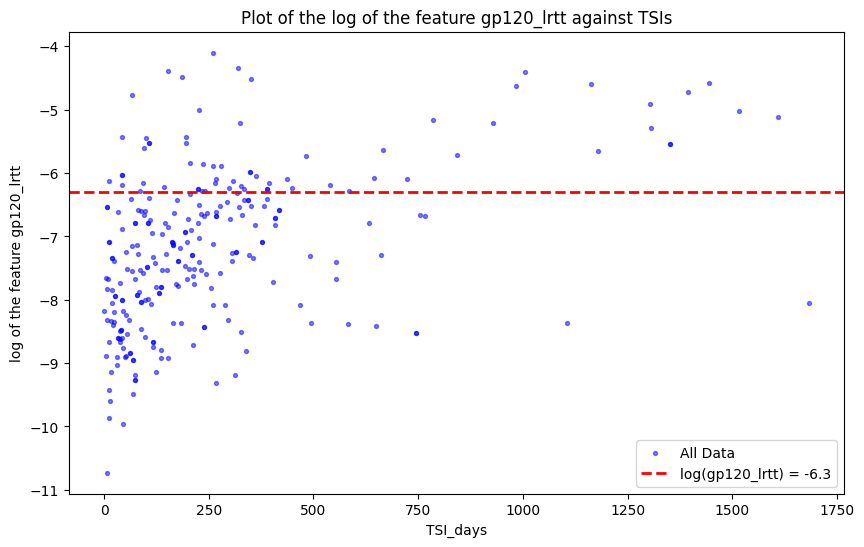

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot of all data
plt.scatter(df_imputed["TSI_days"], np.log(df["gp120_lrtt"]), color='blue', label='All Data', alpha=0.5, s=8)

# Add a horizontal dashed line at y = 0.0025 in red
plt.axhline(y=-6.3, color='red', linestyle='--', linewidth=2, label='log(gp120_lrtt) = -6.3')

# Labels and title
plt.xlabel('TSI_days')
plt.ylabel('log of the feature gp120_lrtt')
plt.title('Plot of the log of the feature gp120_lrtt against TSIs')

# Add a legend
plt.legend()
plt.savefig('gp120_lrttvsTSI.png', format='png', dpi=300, transparent=True)
# Show the plot
plt.show()

Explorations of best/worst subsets

[ 0.25815008 -0.58816668 -0.92331605 -0.95976892 -0.33180949 -0.97601082
 -0.60812474  0.09444697 -0.35313877]
[[ 7.58308628e-02  5.34683376e-01  9.54626818e-03  2.51141199e+00
  -1.04695482e+00 -2.13870630e+00 -1.21033381e+00  2.21724195e-01
  -1.30234508e+00]
 [ 5.34683376e-01  7.58308628e-02 -1.42976652e-01  2.15480257e+00
  -1.06610544e+00 -1.71120771e+00 -1.71686606e+00 -3.57726570e-01
  -1.52872463e+00]
 [ 9.54626818e-03 -1.42976652e-01  7.58308628e-02  2.49431863e+00
   2.10157713e+00 -1.45965794e+00 -2.19207463e+00 -1.32065387e+00
  -1.66090191e+00]
 [ 2.51141199e+00  2.15480257e+00  2.49431863e+00  7.58308628e-02
  -9.90936541e-01 -7.79351017e-01  3.63059719e-01 -4.17740154e+00
  -8.17639029e-01]
 [-1.04695482e+00 -1.06610544e+00  2.10157713e+00 -9.90936541e-01
   7.58308628e-02 -1.20225848e+00  1.33483383e+02 -7.97877774e+00
  -1.39626186e+01]
 [-2.13870630e+00 -1.71120771e+00 -1.45965794e+00 -7.79351017e-01
  -1.20225848e+00  7.58308628e-02 -3.28971809e+00 -9.25567577e-01
  

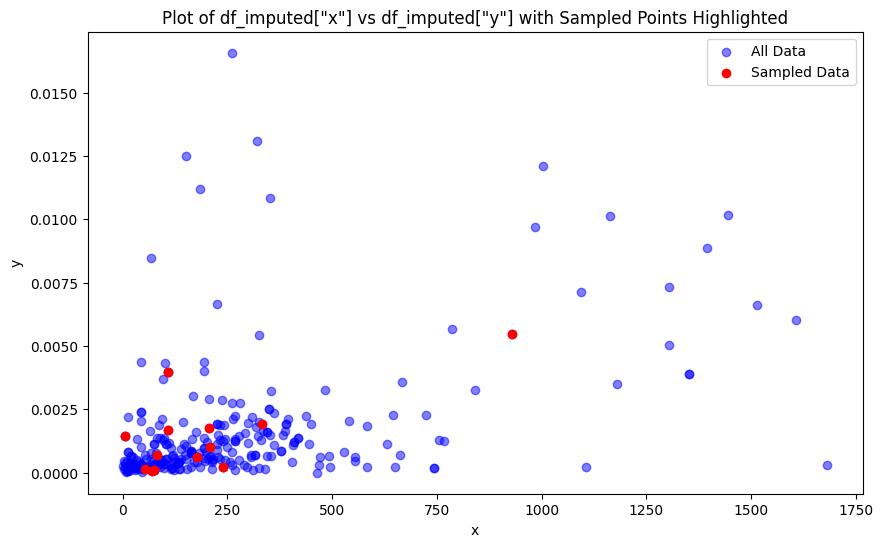

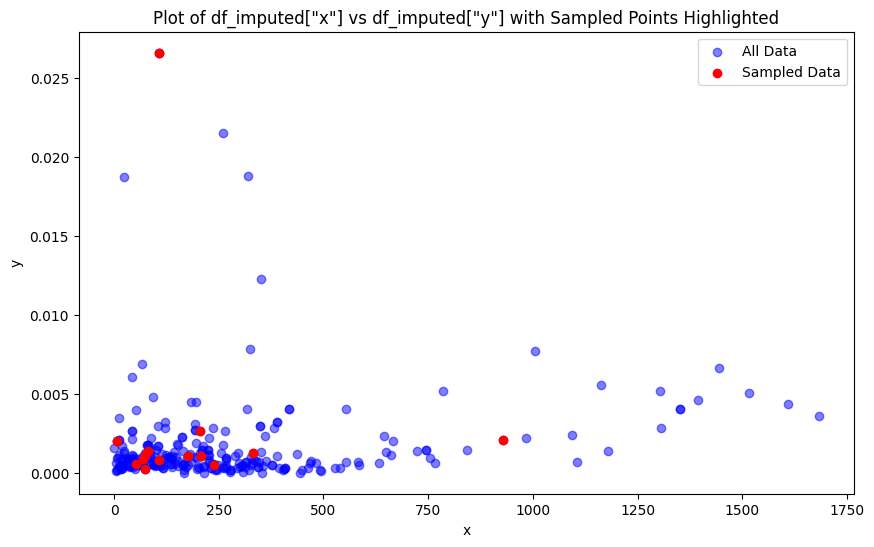

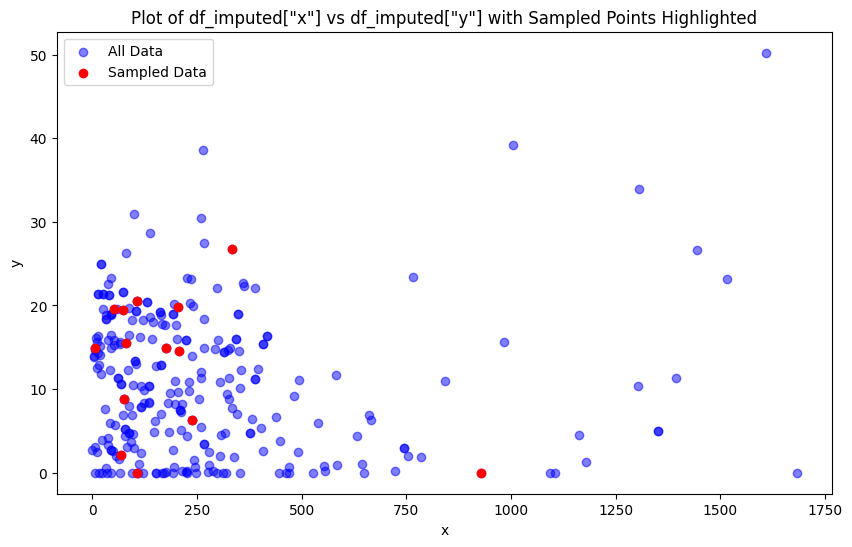

In [ ]:
df_sample = df_imputed.sample(frac=0.05, random_state=140)
X_sample = df_sample[features_of_interest]
covariance_matrix = np.cov(X_sample, rowvar=False)
Best_variances = np.diag(covariance_matrix)
print((Best_variances - Full_variances)/Full_variances)
X_scaled_sample = scaler.fit_transform(X_sample)
covariance_matrix = np.cov(X_scaled_sample, rowvar=False)
Best_covariance = covariance_matrix
print((Best_covariance - Full_covariance)/Full_covariance)


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp120_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp120_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gag_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gag_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp41_tips"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp41_tips"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()

[-0.15778843 -0.58635914 -0.34926727 -0.85424248 -0.2352703  -0.67805536
  0.23670674  1.95833191  1.55191084]
[[ 7.58308628e-02  5.19388747e-01  8.10162623e-01  4.39824024e+00
   3.73135634e+00  3.45117718e+00 -6.84314617e-02  1.40749558e+00
   1.26344644e+00]
 [ 5.19388747e-01  7.58308628e-02  5.25186164e-01  3.82337882e+00
   2.02226642e+00  1.96451147e+00  4.17466085e-01  5.52262474e-01
   7.81811400e-01]
 [ 8.10162623e-01  5.25186164e-01  7.58308628e-02  6.00525486e+00
   2.82586166e+00  2.46764153e+00  7.96658927e-01  6.73949241e-01
   8.92056624e-01]
 [ 4.39824024e+00  3.82337882e+00  6.00525486e+00  7.58308628e-02
   1.89735020e+00  2.11325222e+00 -5.78780988e+00 -8.07667101e+00
  -7.43850322e+00]
 [ 3.73135634e+00  2.02226642e+00  2.82586166e+00  1.89735020e+00
   7.58308628e-02  1.10732559e-01 -2.17955045e+02  6.81662989e+00
   1.72875088e+01]
 [ 3.45117718e+00  1.96451147e+00  2.46764153e+00  2.11325222e+00
   1.10732559e-01  7.58308628e-02  2.66798996e+01  5.92408136e+00
  

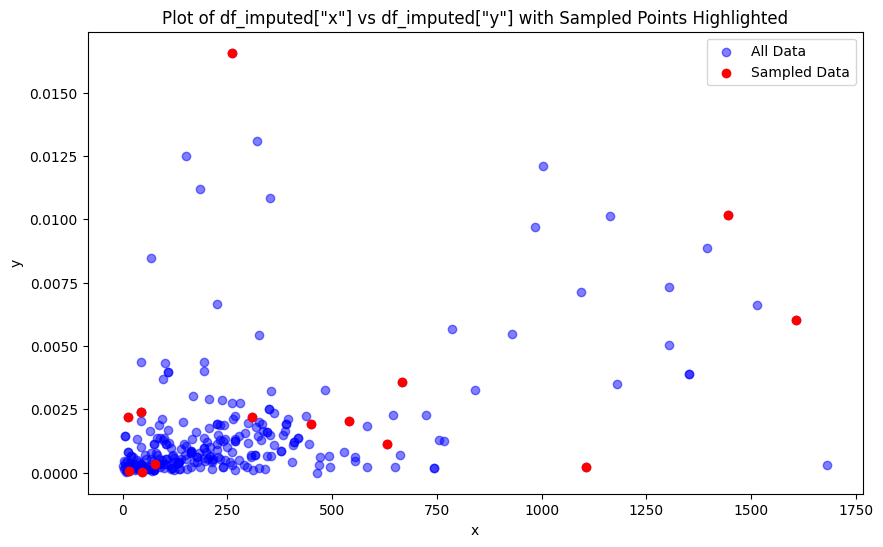

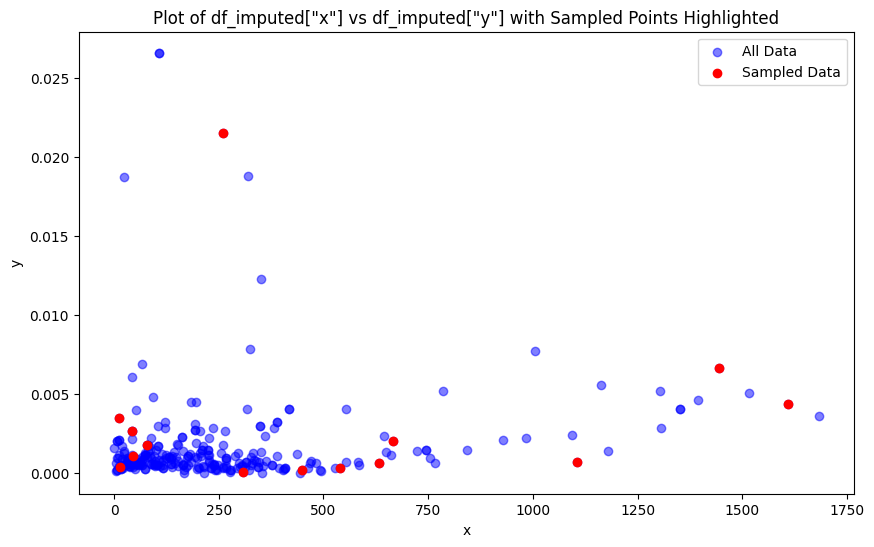

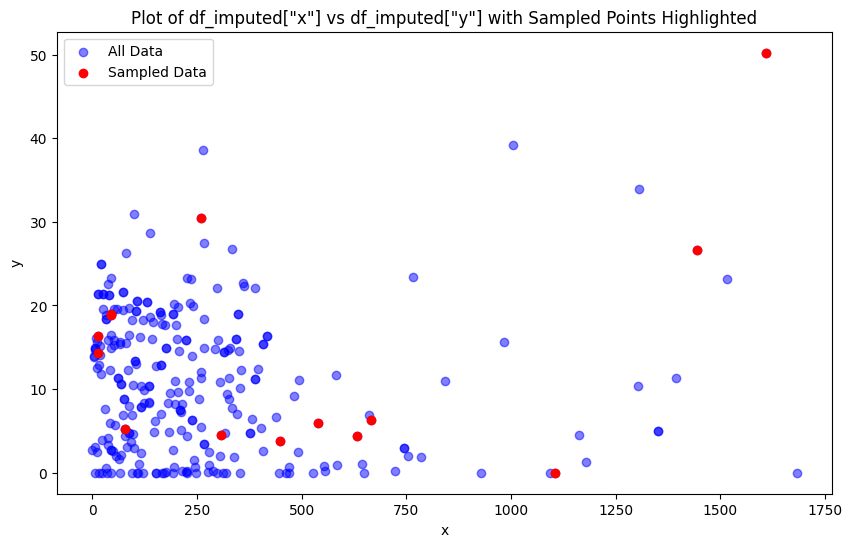

In [ ]:
df_sample = df_imputed.sample(frac=0.05, random_state=14)
X_sample = df_sample[features_of_interest]
covariance_matrix = np.cov(X_sample, rowvar=False)
Best_variances = np.diag(covariance_matrix)
print((Best_variances - Full_variances)/Full_variances)
X_scaled_sample = scaler.fit_transform(X_sample)
covariance_matrix = np.cov(X_scaled_sample, rowvar=False)
Best_covariance = covariance_matrix
print((Best_covariance - Full_covariance)/Full_covariance)


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp120_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp120_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gag_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gag_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp41_tips"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp41_tips"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()

[-0.96239961 -0.97040903 -0.95620772 -0.95696468 -0.87439866 -0.9651611
 -0.28209726  0.58720366  0.85947354]
[[ 7.58308628e-02 -7.48602065e-01 -2.02020335e-01  3.52373868e+00
  -1.28130220e+00  4.79500264e-01 -1.94530112e-02  2.36122227e-01
  -4.71231459e-01]
 [-7.48602065e-01  7.58308628e-02  3.87652034e-02 -1.22953292e+00
  -1.41001696e+00  6.17028991e-01 -1.91331993e+00 -1.36802748e+00
  -2.04539842e+00]
 [-2.02020335e-01  3.87652034e-02  7.58308628e-02 -1.10399656e-01
  -2.34739423e+00 -4.83396656e-01 -1.36752763e+00 -6.62602068e-01
  -1.15850128e+00]
 [ 3.52373868e+00 -1.22953292e+00 -1.10399656e-01  7.58308628e-02
  -2.51500209e-02 -3.13656641e-01 -5.86610964e+00 -2.83202666e+00
  -2.16496343e+00]
 [-1.28130220e+00 -1.41001696e+00 -2.34739423e+00 -2.51500209e-02
   7.58308628e-02 -9.22216168e-01 -2.41046843e+01 -7.63222900e-01
  -3.67752136e+00]
 [ 4.79500264e-01  6.17028991e-01 -4.83396656e-01 -3.13656641e-01
  -9.22216168e-01  7.58308628e-02  1.10291611e+01  7.59485854e-01
   

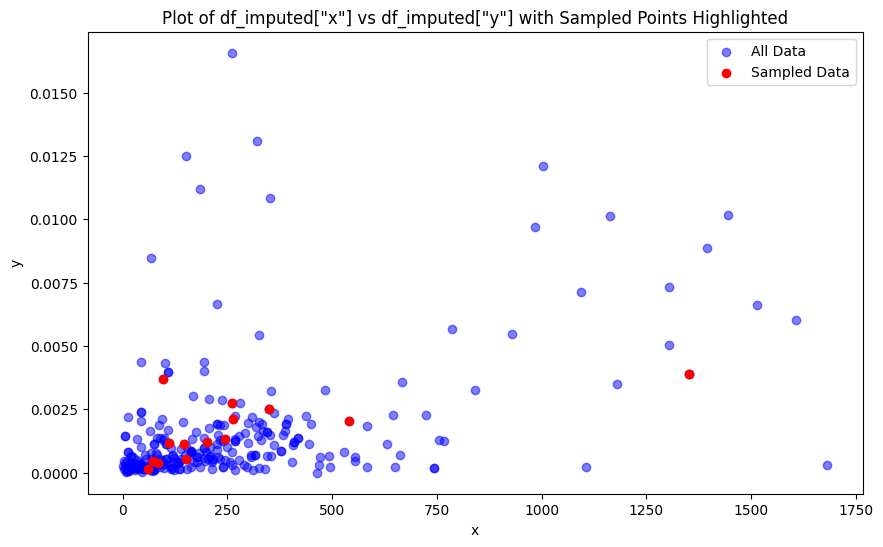

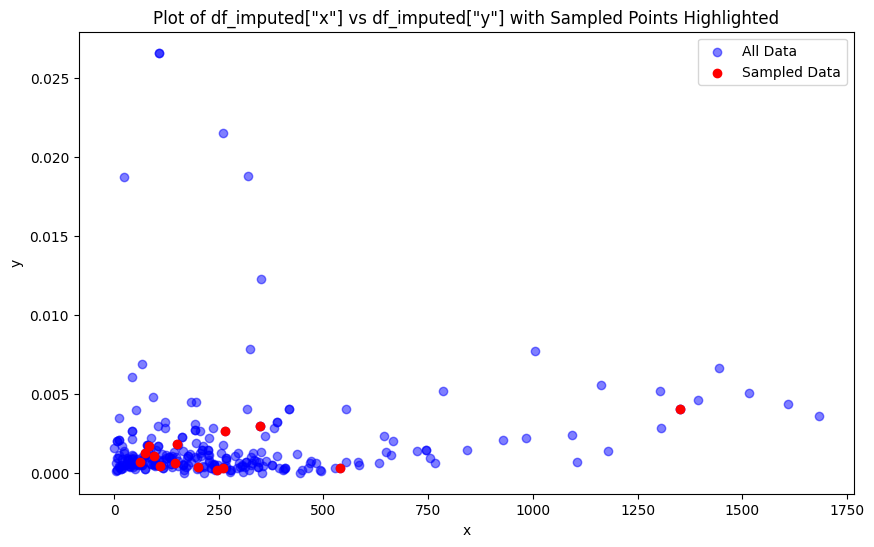

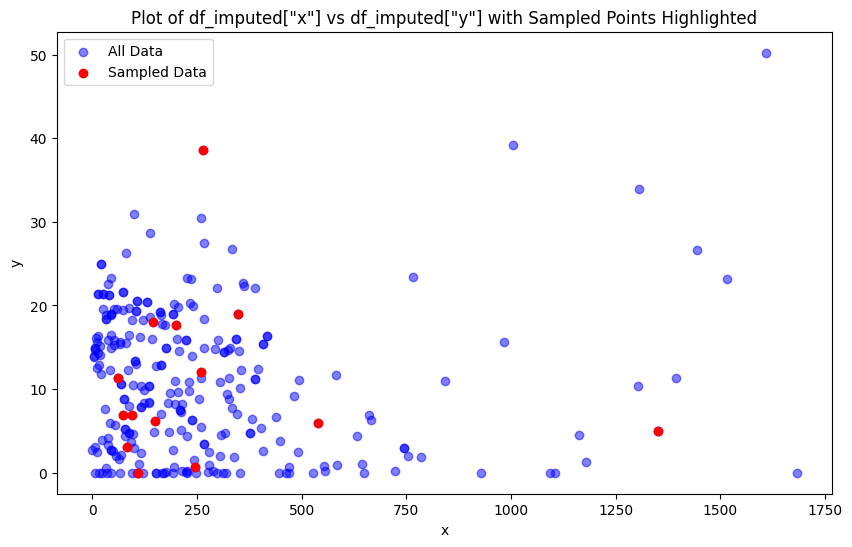

In [ ]:
df_sample = df_imputed.sample(frac=0.05, random_state=297)
X_sample = df_sample[features_of_interest]
covariance_matrix = np.cov(X_sample, rowvar=False)
Best_variances = np.diag(covariance_matrix)
print((Best_variances - Full_variances)/Full_variances)
X_scaled_sample = scaler.fit_transform(X_sample)
covariance_matrix = np.cov(X_scaled_sample, rowvar=False)
Best_covariance = covariance_matrix
print((Best_covariance - Full_covariance)/Full_covariance)


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp120_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp120_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gag_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gag_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp41_tips"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp41_tips"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()

[ 3.7041152   2.22700543 -0.12066088 -0.64492687 -0.67146421 -0.82085509
  0.51909583  1.07268837  0.52424655]
[[  0.0731042    0.45060816  -0.20970409   0.11573931  -0.08533173
   -1.60885804  14.6472526    0.53419728   0.42472703]
 [  0.45060816   0.0731042   -0.07170266   1.54865441   0.395774
   -0.66913972 -12.66789806   1.81932358   3.60856784]
 [ -0.20970409  -0.07170266   0.0731042    0.4926533    2.30989092
    1.3699637   21.18640686   2.80824218   3.42829017]
 [  0.11573931   1.54865441   0.4926533    0.0731042    0.39187687
    0.02386756  -0.88803812  -1.79610714  -0.54768807]
 [ -0.08533173   0.395774     2.30989092   0.39187687   0.0731042
    0.05341248  -2.24226442  -3.21649237  -2.07193027]
 [ -1.60885804  -0.66913972   1.3699637    0.02386756   0.05341248
    0.0731042   -2.28119173  -5.49600201  -2.28290678]
 [ 14.6472526  -12.66789806  21.18640686  -0.88803812  -2.24226442
   -2.28119173   0.0731042    0.38363416   0.26493715]
 [  0.53419728   1.81932358   2.808242

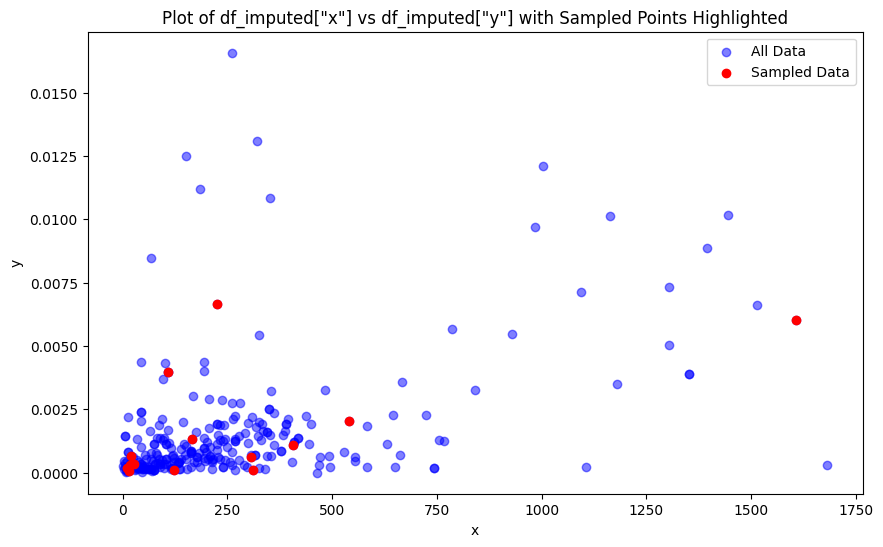

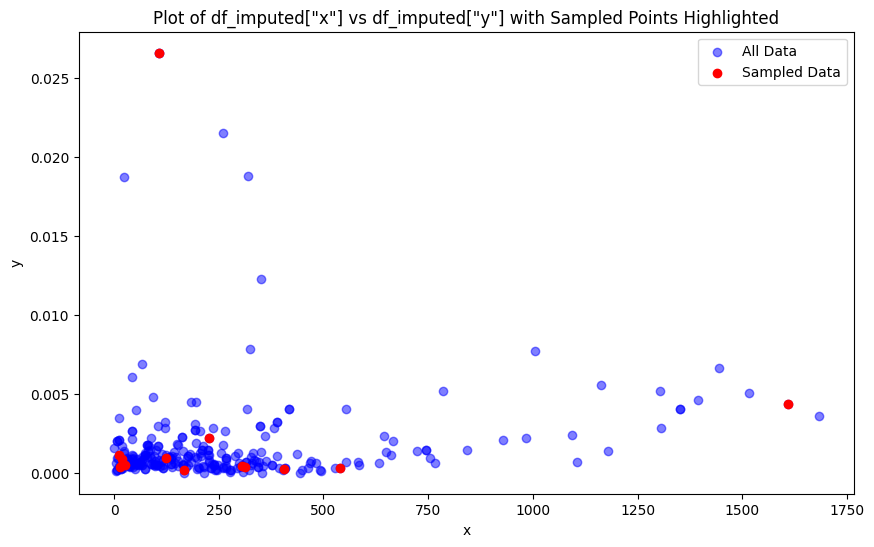

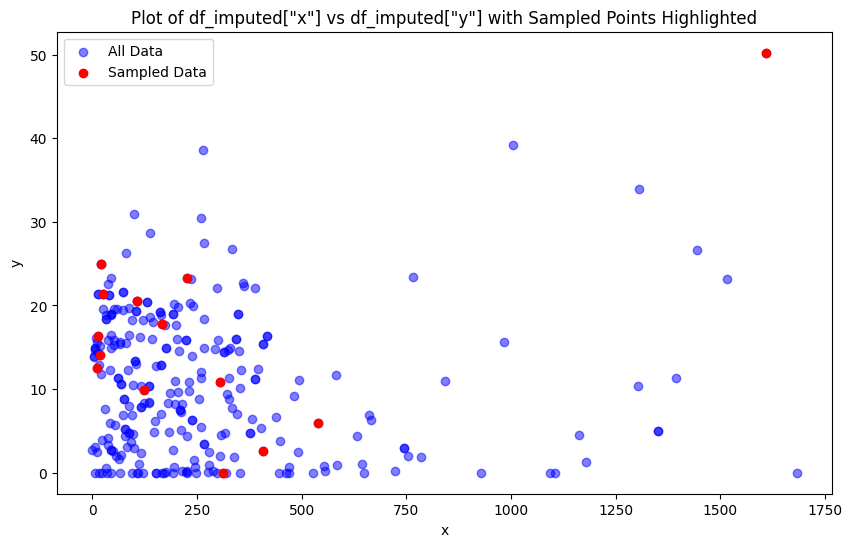

In [ ]:
df_sample = df_imputed.sample(frac=0.05, random_state=112)
X_sample = df_sample[features_of_interest]
covariance_matrix = np.cov(X_sample, rowvar=False)
Best_variances = np.diag(covariance_matrix)
print((Best_variances - Full_variances)/Full_variances)
X_scaled_sample = scaler.fit_transform(X_sample)
covariance_matrix = np.cov(X_scaled_sample, rowvar=False)
Best_covariance = covariance_matrix
print((Best_covariance - Full_covariance)/Full_covariance)


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp120_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp120_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gag_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gag_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp41_tips"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp41_tips"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()

[-0.74101912 -0.35413017  1.04966404  1.17006755 -0.14275038 -0.37975362
 -0.18485949 -0.29519168 -0.09799066]
[[ 0.0731042   0.0910423   0.2426409  -1.55097554 -1.44549182 -2.14534449
  -4.28717319 -0.02310836 -2.91783168]
 [ 0.0910423   0.0731042   0.09351656 -1.12849176  0.05506834 -0.56291716
   8.91399604 -1.49584585 -2.93307029]
 [ 0.2426409   0.09351656  0.0731042  -1.98033757  0.07113642 -1.1416829
  -1.10838015 -0.14337174 -0.36529039]
 [-1.55097554 -1.12849176 -1.98033757  0.0731042  -0.89862354 -1.10758522
  -0.6872576   0.8548053  -0.08347463]
 [-1.44549182  0.05506834  0.07113642 -0.89862354  0.0731042  -0.16144055
   0.38192411  0.84804981 -0.10933541]
 [-2.14534449 -0.56291716 -1.1416829  -1.10758522 -0.16144055  0.0731042
  -0.14376633 -0.53062013 -0.31619445]
 [-4.28717319  8.91399604 -1.10838015 -0.6872576   0.38192411 -0.14376633
   0.0731042   0.08960575 -0.01810574]
 [-0.02310836 -1.49584585 -0.14337174  0.8548053   0.84804981 -0.53062013
   0.08960575  0.0731042  

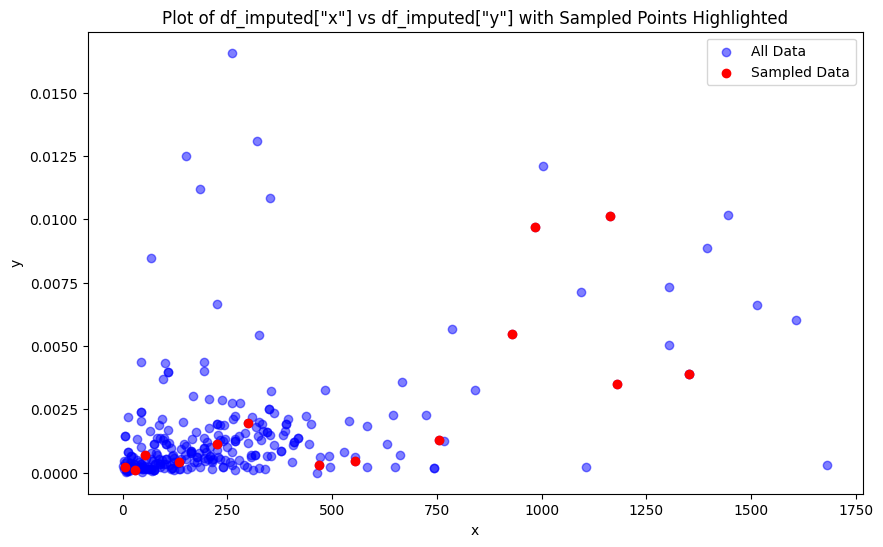

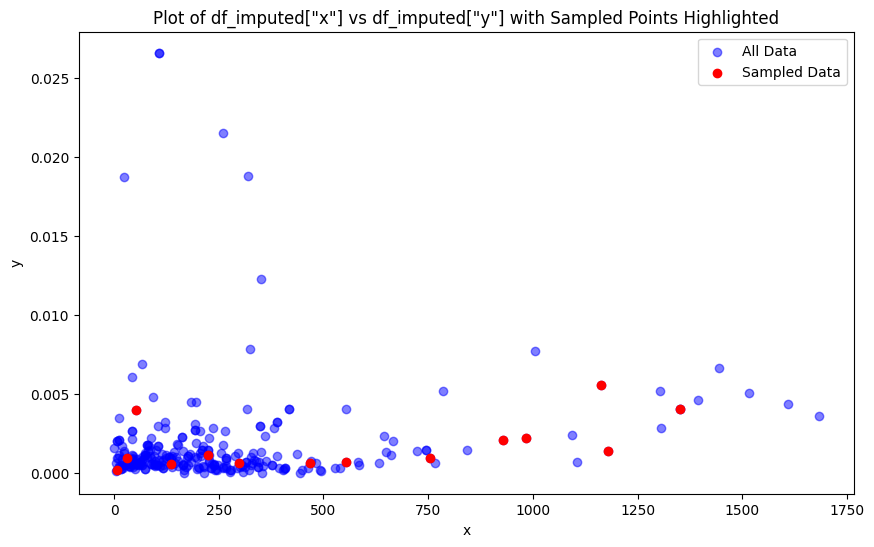

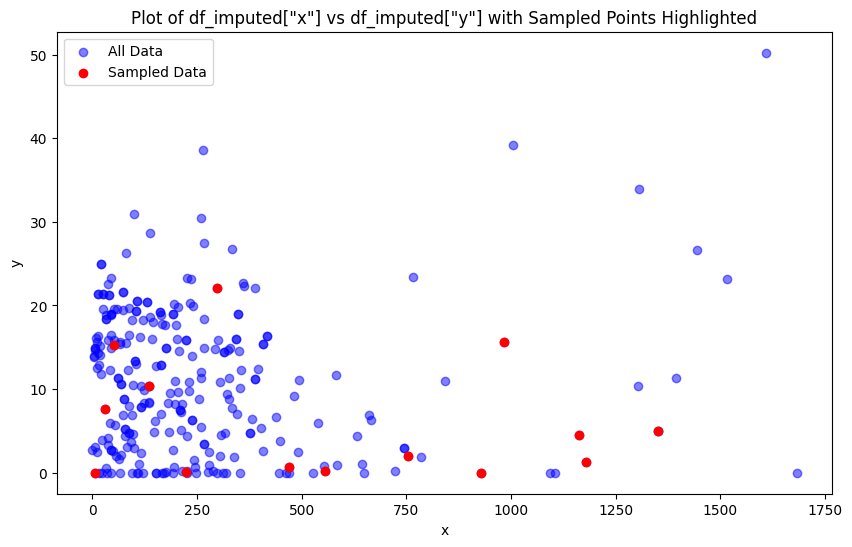

In [ ]:
df_sample = df_imputed.sample(frac=0.05, random_state=85)
X_sample = df_sample[features_of_interest]
covariance_matrix = np.cov(X_sample, rowvar=False)
Best_variances = np.diag(covariance_matrix)
print((Best_variances - Full_variances)/Full_variances)
X_scaled_sample = scaler.fit_transform(X_sample)
covariance_matrix = np.cov(X_scaled_sample, rowvar=False)
Best_covariance = covariance_matrix
print((Best_covariance - Full_covariance)/Full_covariance)


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp120_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp120_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gag_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gag_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp41_tips"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp41_tips"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()

[ 0.14342585  0.57009057  1.45287689 -0.89870856 -0.75275148 -0.63479739
 -0.09855842  1.03884371  0.5803918 ]
[[ 7.31042008e-02  2.50981916e-01  7.15825625e-01  7.85656427e-01
  -7.45766591e-02  8.21006640e-01  1.09843647e+01  2.03699592e+00
   6.65035228e+00]
 [ 2.50981916e-01  7.31042008e-02  3.26150127e-01  1.49329206e+00
   4.79910769e-01  7.72354770e-01  4.03709601e-01  2.52979209e+00
   9.14294924e+00]
 [ 7.15825625e-01  3.26150127e-01  7.31042008e-02  1.20993986e+00
   1.81078216e-03  1.20366117e+00  9.83159567e+00  2.96139133e+00
   3.94857289e+00]
 [ 7.85656427e-01  1.49329206e+00  1.20993986e+00  7.31042008e-02
  -3.72671988e-01 -4.29925928e-01 -1.67163532e+00 -4.88367671e+00
  -2.66138702e+00]
 [-7.45766591e-02  4.79910769e-01  1.81078216e-03 -3.72671988e-01
   7.31042008e-02  1.35354592e-02 -1.68255010e+00 -2.67250882e+00
  -1.44845005e+00]
 [ 8.21006640e-01  7.72354770e-01  1.20366117e+00 -4.29925928e-01
   1.35354592e-02  7.31042008e-02 -2.03240184e+00 -5.54728713e+00
  

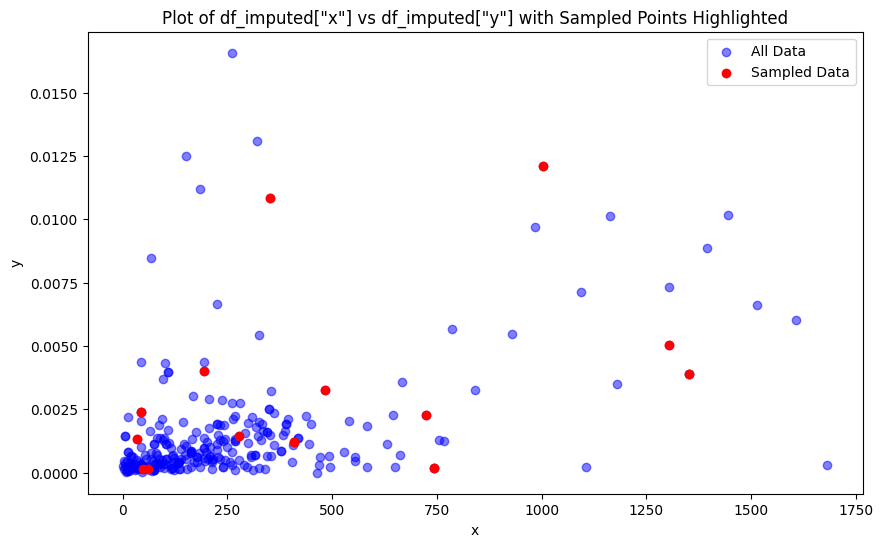

209     278.0
103    1004.0
126      44.0
256      34.0
163     408.0
115     482.0
223     724.0
165     744.0
200     351.0
264     195.0
185    1305.0
70       49.0
39       61.0
166    1351.0
Name: TSI_days, dtype: float64


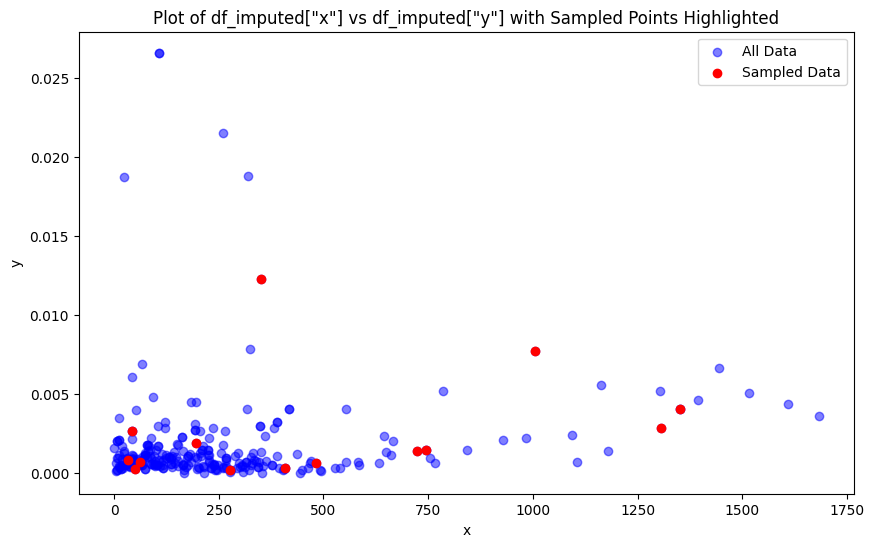

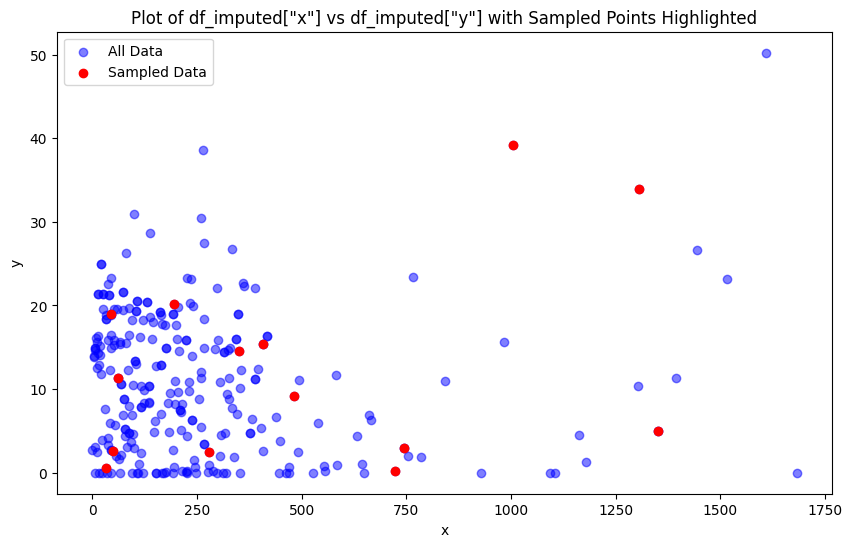

In [ ]:
df_sample = df_imputed.sample(frac=0.05, random_state=288)
X_sample = df_sample[features_of_interest]
covariance_matrix = np.cov(X_sample, rowvar=False)
Best_variances = np.diag(covariance_matrix)
print((Best_variances - Full_variances)/Full_variances)
X_scaled_sample = scaler.fit_transform(X_sample)
covariance_matrix = np.cov(X_scaled_sample, rowvar=False)
Best_covariance = covariance_matrix
print((Best_covariance - Full_covariance)/Full_covariance)


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp120_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp120_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()
print(df_sample["TSI_days"])

plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gag_lrtt"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gag_lrtt"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_imputed["TSI_days"], df_imputed["gp41_tips"], color='blue', label='All Data', alpha=0.5)

# Highlighting the sampled points
plt.scatter(df_sample["TSI_days"], df_sample["gp41_tips"], color='red', label='Sampled Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of df_imputed["x"] vs df_imputed["y"] with Sampled Points Highlighted')
plt.legend()
plt.show()

**Appendix: Ordering of imputation and standardization**

In [8]:
# List of features
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing
df_filtered = df[features_of_interest + [target_variable]]
X = df_filtered[features_of_interest].values
y = df_filtered[target_variable].values
scaler = StandardcaSler()
X_scaled = scaler.fit_transform(X)
imputer = KNNImputer(n_neighbors=5)
X_scaled = pd.DataFrame(imputer.fit_transform(X_scaled), columns=df_filtered[features_of_interest].columns)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)  # Reshaping y to make it suitable for TensorFlow

# Set up the 20-fold cross-validation
kf = KFold(n_splits=20, shuffle=True, random_state=42)
nmae_scores = []
R2_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    # Define your 1D-CNN model
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='softplus')
    ])

    # Fit the model
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=200,
        decay_rate=0.95,
        staircase=False)  # staircase=False for smooth exponential decay

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0)

    # Evaluate the model
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    nmae = mae / np.mean(y_test)
    nmae_scores.append(nmae)
    R2_scores.append(r2)

# Bootstrap resampling to compute the 95% confidence interval
n_bootstrap_samples = 1000
bootstrap_means = []
bootstrap_r2 = []

np.random.seed(42)
for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(nmae_scores, size=len(nmae_scores), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(bootstrap_mean)
    bootstrap_sample = np.random.choice(R2_scores, size=len(R2_scores), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_r2.append(bootstrap_mean)

# Calculate the 95% confidence interval
ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)

print(f"Mean MAE: {np.mean(nmae_scores)}")
print(f"Mean R square: {np.mean(R2_scores)}")
print(f"95% Bootstrap Confidence Interval for MAE: ({ci_lower}, {ci_upper})")

ci_lower = np.percentile(bootstrap_r2, 2.5)
ci_upper = np.percentile(bootstrap_r2, 97.5)
print(f"95% Bootstrap Confidence Interval for R square: ({ci_lower}, {ci_upper})")


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in subtract
  temp = X - T
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:1025: RuntimeWarning: invalid value encountered in subtract
  X -= self.mean_
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Mean MAE: 0.4700434180257337
Mean R square: 0.33268418873325806
95% Bootstrap Confidence Interval for MAE: (0.4196828695475746, 0.5253498900220339)
95% Bootstrap Confidence Interval for R square: (0.14102425761259424, 0.5091731236578061)


In [9]:
# Uganda dataset
features_of_interest = ['gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'gp41_maf12c', 'gag_tips', 'gp41_tips', 'gp120_tips']
target_variable = 'TSI_days'

# Preprocessing
df_filtered = Rakai_MAF[features_of_interest + [target_variable]]
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)
X = df_imputed[features_of_interest].values
y = df_imputed[target_variable].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to numpy array and reshape for TensorFlow
y = y.reshape(-1, 1)  # Reshaping y to make it suitable for TensorFlow

# Set up the 20-fold cross-validation
kf = KFold(n_splits=20, shuffle=True, random_state=42)
nmae_scores = []
R2_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    # Define your 1D-CNN model
    model = tf.keras.Sequential([
            tf.keras.layers.Reshape((9, 1), input_shape=(9,)),
            tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv1D(filters=4, kernel_size=2, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='softplus')
        ])
    # Fit the model
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=120,
            decay_rate=0.95,
            staircase=False)  # staircase=False for smooth exponential decay

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                      loss='mean_squared_error',
                      metrics=['mean_absolute_error'])
    model.fit(X_train, y_train, epochs=120, batch_size=32, verbose=0)

    # Evaluate the model
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    nmae = mae/np.mean(y_test)
    nmae_scores.append(nmae)
    R2_scores.append(r2)

# Bootstrap resampling to compute the 95% confidence interval
n_bootstrap_samples = 1000
bootstrap_means = []
bootstrap_r2 = []

np.random.seed(42)
for _ in range(n_bootstrap_samples):
    bootstrap_sample = np.random.choice(nmae_scores, size=len(nmae_scores), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(bootstrap_mean)
    bootstrap_sample = np.random.choice(R2_scores, size=len(R2_scores), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_r2.append(bootstrap_mean)

# Calculate the 95% confidence interval
ci_lower = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)


print(f"Mean MAE: {np.mean(nmae_scores)}")
print(f"Mean R square: {np.mean(R2_scores)}")
print(f"95% Bootstrap Confidence Interval for MAE: ({ci_lower}, {ci_upper})")
ci_lower = np.percentile(bootstrap_r2, 2.5)
ci_upper = np.percentile(bootstrap_r2, 97.5)
print(f"95% Bootstrap Confidence Interval for R square: ({ci_lower}, {ci_upper})")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Mean MAE: 0.47996083092713626
Mean R square: 0.4251717125649955
95% Bootstrap Confidence Interval for MAE: (0.4548088194841401, 0.5021280157909629)
95% Bootstrap Confidence Interval for R square: (0.38444585591368435, 0.4681840321409851)
